# Оптимизация работы предприятия "Цифра"

**Целью** нашего проекта будет являться создание модели, которая  должна предсказать коэффициент восстановления золота из золотосодержащей руды согласно технологическому процессу предприятия "Цифра". 

Данная модель позволить оптимизировать производственный цикл и предотвратит возможную убыточность работы предприятия. 

Основным изучаемым и исследуемым нами параметром будет являться **эффективность обогащения**. Исходными сведениями будут данные, которые описывают весь технологический процесс отчистки полезных металлов. Данные изначально распределены в трех файлах - обучающая выборка модели, тестовая выборка модели и исходные данные. 

Общее описание данных может быть представлено в следующем виде: 

**Технологический процесс**
- Rougher feed — исходное сырье
- Rougher additions (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant
- Xanthate — ксантогенат (промотер, или активатор флотации);
- Sulphate — сульфат (на данном производстве сульфид натрия);
- Depressant — депрессант (силикат натрия).
- Rougher process (англ. «грубый процесс») — флотация
- Rougher tails — отвальные хвосты
- Float banks — флотационная установка
- Cleaner process — очистка
- Rougher Au — черновой концентрат золота
- Final Au — финальный концентрат золота <br><br>
**Параметры этапов**
- air amount — объём воздуха
- fluid levels — уровень жидкости
- feed size — размер гранул сырья
- feed rate — скорость подачи

В ходе проекта мы проведем предобработку данных и их предварительный анализ - рассмотрим, как изменяется концентрация металлов на различных этапах обработки, сравним распределения размеров гранул исходного сырья на обучающей и тестовой выборках и исследуем суммарную концентрацию металлов на разных стадиях.

Для анализа эффективности разрабатываемой модели мы воспользуемся метрикой **sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Обучив разные модели и определив наиболее эффективную, мы проверим полученные результаты при помощи кросс-валидации. 

# 1. Предобработка данных 

В ходе предобработки данных загрузим имеющиеся датафреймы, проверим данные на целостность - на количество дубликатов, пропусков, соответствие типов данных, наличие аномальных значений, на распределения имеющихся значений. Определим правильность имеющихся расчетов эффективности обогащения, вычислим эту величину для обучающей выборки на признаке rogher.output.recovery. Определим эффективность полученных расчетов с помощью параметра MAE. Проанализируем также признаки, недоступные в тестовой выборке. 

In [1]:
#Импортируем все используемые в проекте библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from numpy.random import RandomState
import matplotlib.colors as cm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

In [2]:
#Считываем csv файлы с данными и сохраняем их в соответсвующие датафреймы
try:
    data_train = pd.read_csv('/datasets/gold_industry_train.csv')
    data_test = pd.read_csv('/datasets/gold_industry_test.csv')
    data_full = pd.read_csv('/datasets/gold_industry_full.csv')
except:
    data_train = pd.read_csv('gold_industry_train.csv')  
    data_test = pd.read_csv('gold_industry_test.csv') 
    data_full = pd.read_csv('gold_industry_full.csv') 

Проанализируем возможные дубликаты в исходных данных.

In [3]:
print(data_train.duplicated().sum())
print(data_test.duplicated().sum())
print(data_full.duplicated().sum())

0
0
0


In [4]:
print('Пропуски в data_train', data_train.isna().sum().sum())
print('Пропуски в data_test', data_test.isna().sum().sum())
print('Пропуски в data_full', data_full.isna().sum().sum())

Пропуски в data_train 3050
Пропуски в data_test 375
Пропуски в data_full 4481


Очевидно, что возможно наличие неявных дубликатов по времени - date. Проверим наличие таких дубликатов.

In [5]:
print(data_train['date'].duplicated().sum())
print(data_test['date'].duplicated().sum())
print(data_full['date'].duplicated().sum())

0
0
0


Пропуски заполним ближайшими значениями, поскольку близкие по времени данные похожи.

In [6]:
#Заполнение ближайшими значениями
data_train = data_train.fillna(method='bfill')
data_test = data_test.fillna(method='bfill')
data_full = data_full.fillna(method='bfill')

**Вывод**: все данные были считанные в отдельные датафреймы. Явных дубликатов в данных необнаружено, но в каждом найдены пропущенные значения. Также не обнаружено неявных дубликатов по времени поступления. 

Более детально проанализируем информацию по каждому датафрейму. 

In [7]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14579 non-null  float64
 4   rougher.input.feed_sol                              14579 non-null  float64
 5   rougher.input.feed_rate                             14579 non-null  float64
 6   rougher.input.feed_size                             14579 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14579 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14579 non-null  float64


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4860 non-null   float64
 4   rougher.input.feed_sol                      4860 non-null   float64
 5   rougher.input.feed_rate                     4860 non-null   float64
 6   rougher.input.feed_size                     4860 non-null   float64
 7   rougher.input.floatbank10_sulfate           4860 non-null   float64
 8   rougher.input.floatbank10_xanthate          4860 non-null   float64
 9   rougher.state.floatbank10_a_air             4860 non-null   float64
 10  rougher.stat

**Вывод**: видно, что параметров для тестовой выборки меньше, чем параметров в обучающей выборке. Видно, что в этой выборке отсутствуют целевые параметры  - recovery, выходные данные технологических процессов, а также расчетные значения.


В обучающей выборке таким образом уже доступны те данные, которые мы получаем после обработки и после завершения работы, а в тестовой только те данные, которые будут необходимы для формирования прогноза - т.е. имитируется реальная ситуация для работы модели обучения.    

In [9]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19439 non-null  float64
 4   rougher.input.feed_sol                              19439 non-null  float64
 5   rougher.input.feed_rate                             19439 non-null  float64
 6   rougher.input.feed_size                             19439 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19439 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19439 non-null  float64


**Вывод**: поскольку большая часть технологических характеристик имеет численное значение, поэтому представляемое типом данных float64 является уместным. Для данных о времени можно провести оптимизацию и преобразовать в более удобных для обработки тип datetime. 

In [10]:
#Переведем данные даты в формат datetime
data_train['date'] = pd.to_datetime(
    data_train['date'], format='%Y-%m-%dT%H:%M:%S'
)
data_test['date'] = pd.to_datetime(
    data_test['date'], format='%Y-%m-%dT%H:%M:%S'
)
data_full['date'] = pd.to_datetime(
    data_full['date'], format='%Y-%m-%dT%H:%M:%S'
)

Проанализируем теперь имеющиеся данные на возможные аномалии. Построим визуализацию имеющихся параметров при помощи **гистограмм**. 

In [11]:
#Уберем для отображения данных стобец с датой
data_train_t= data_train.drop('date', axis = 1)
column = pd.Series(data_train_t.columns)
data_test_t = data_test.drop('date', axis = 1)
column_test = pd.Series(data_test_t.columns)
data_full_t = data_full.drop('date', axis = 1)

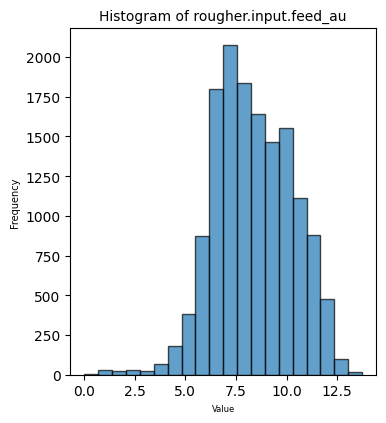

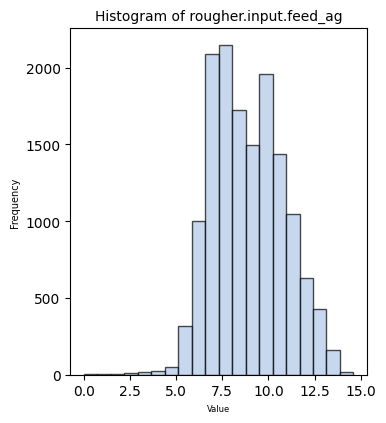

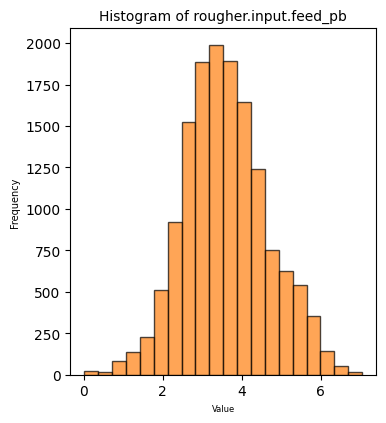

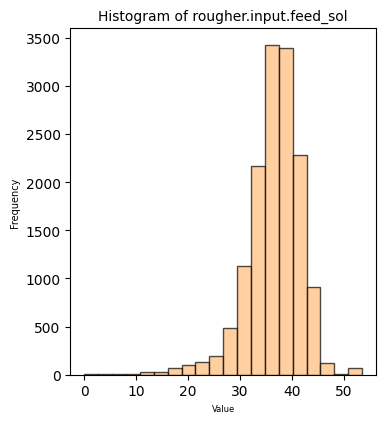

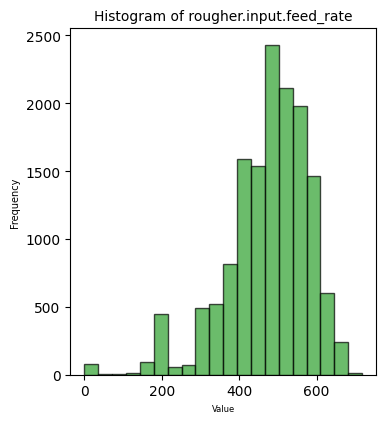

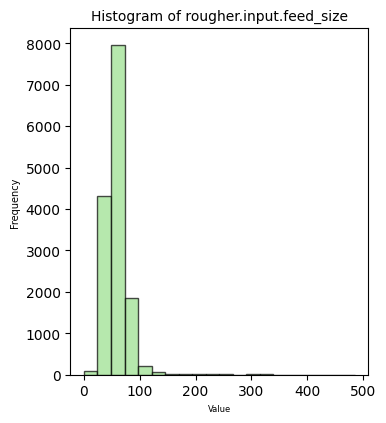

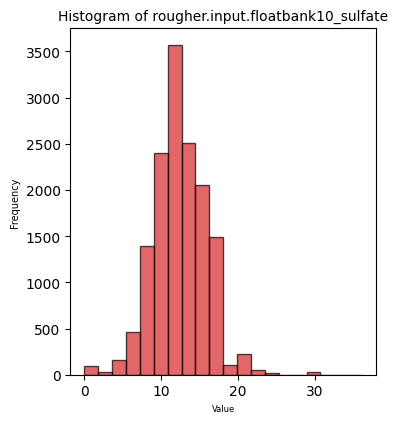

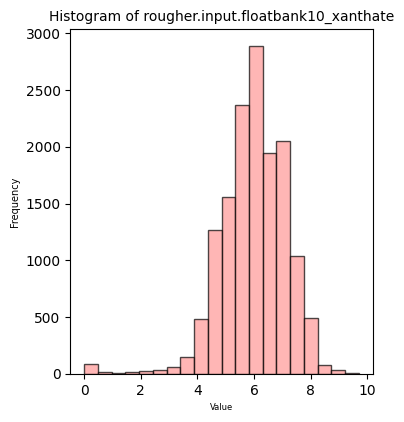

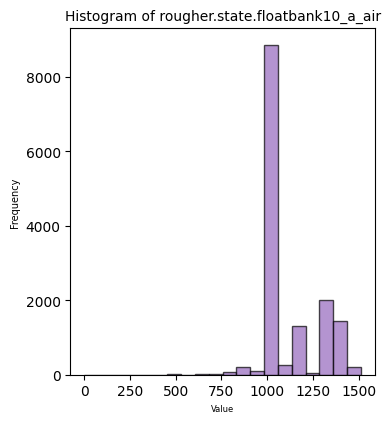

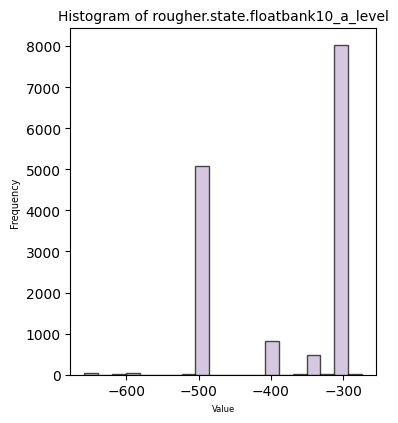

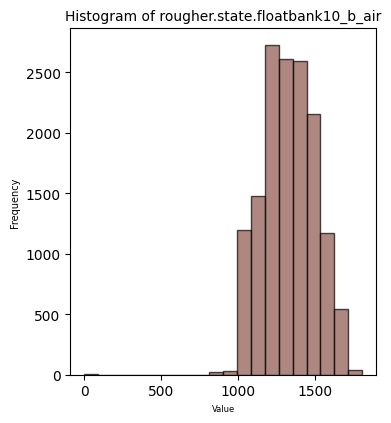

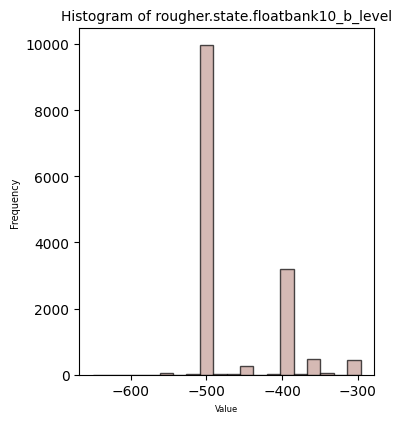

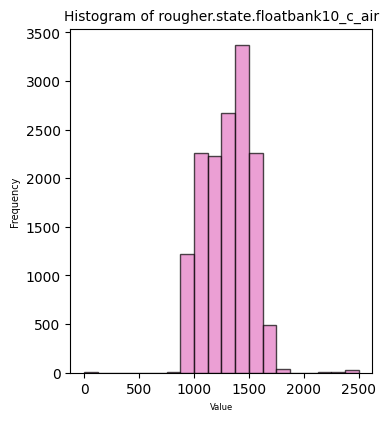

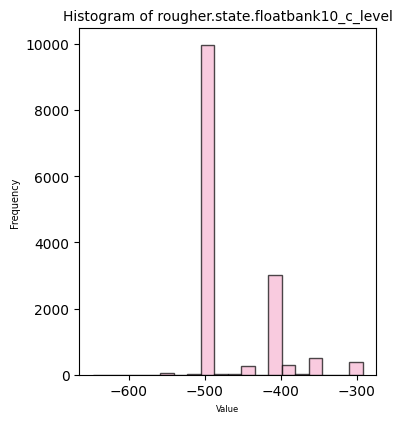

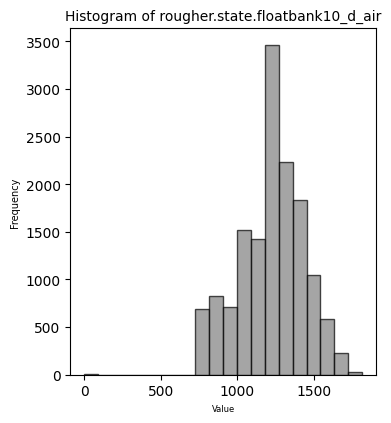

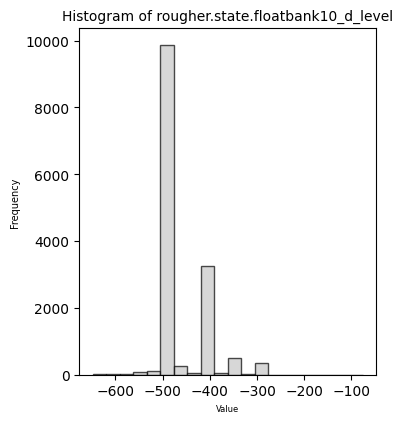

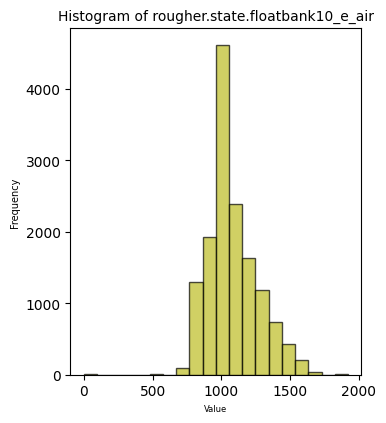

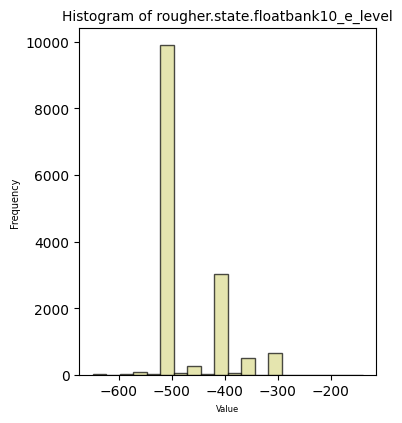

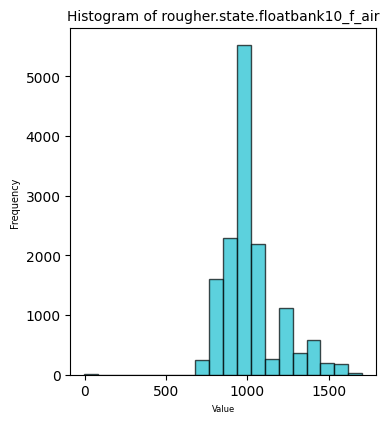

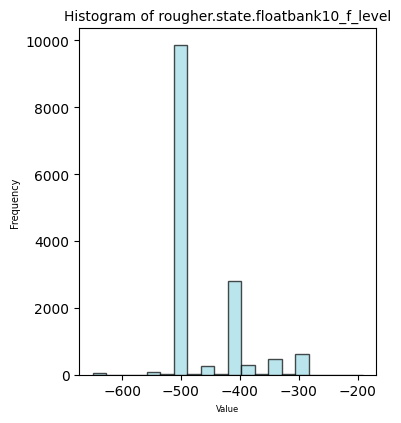

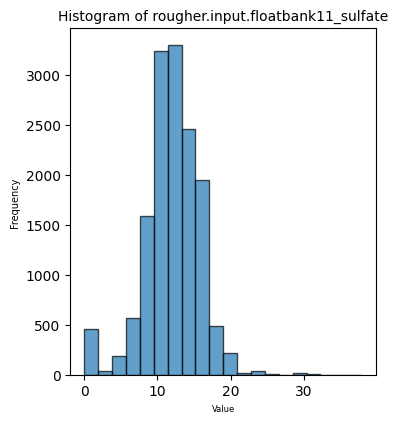

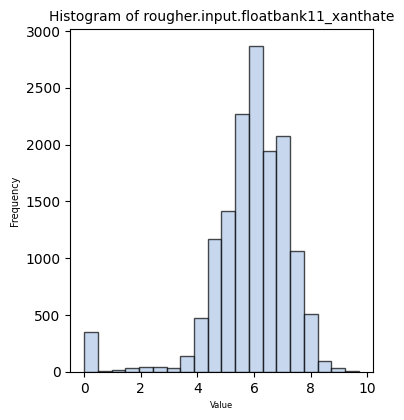

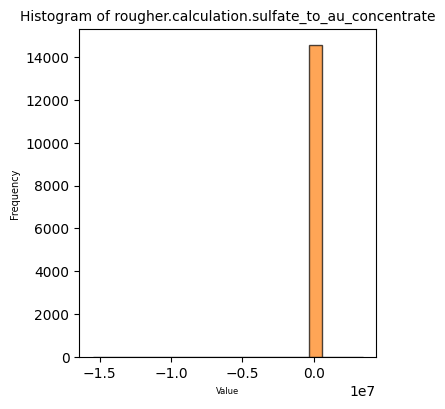

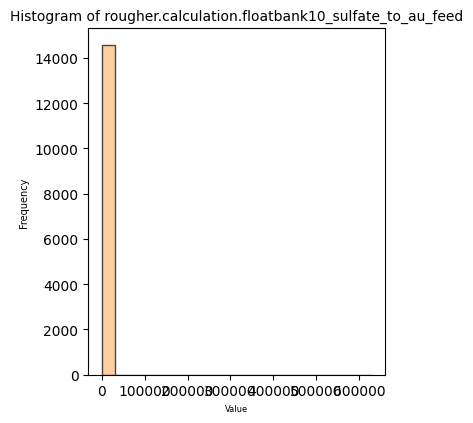

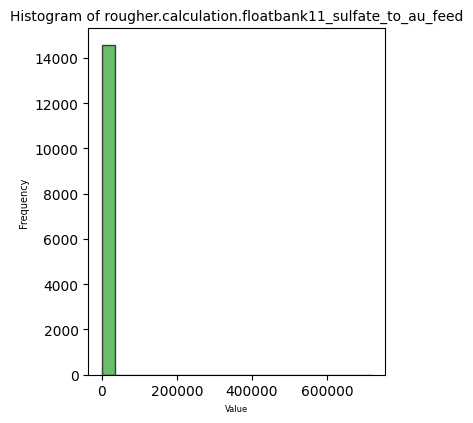

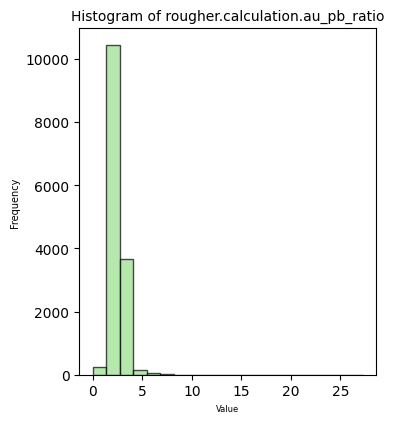

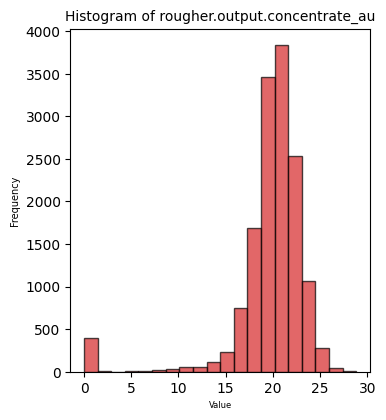

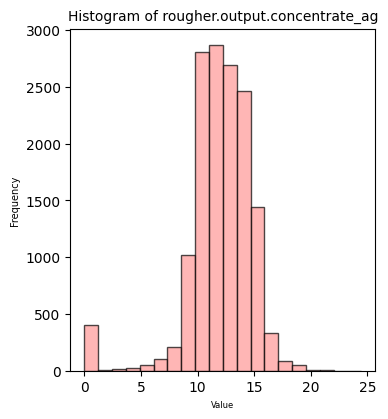

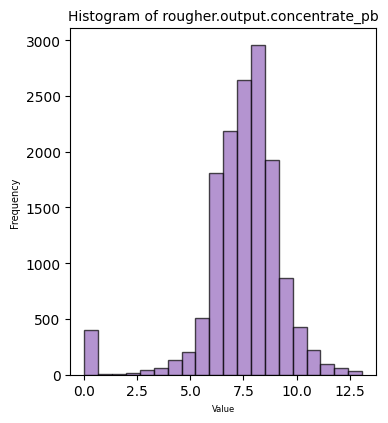

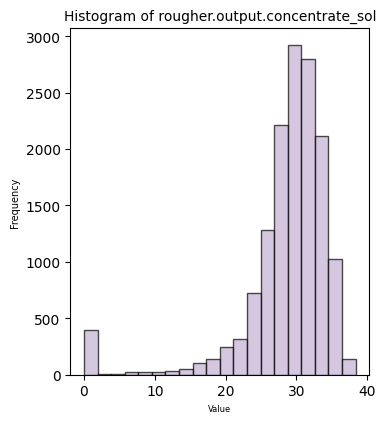

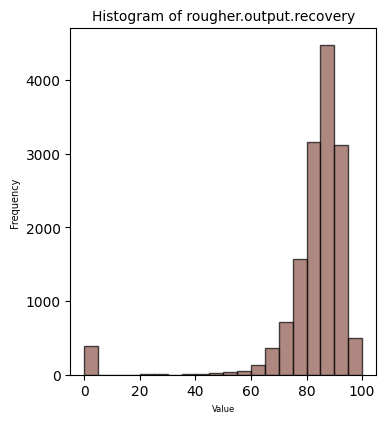

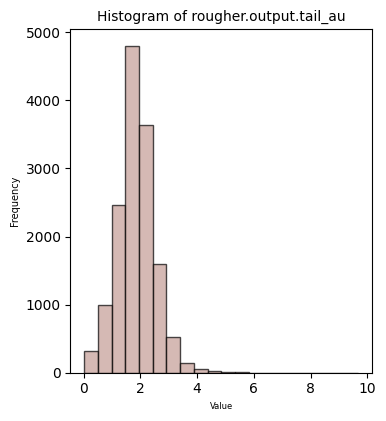

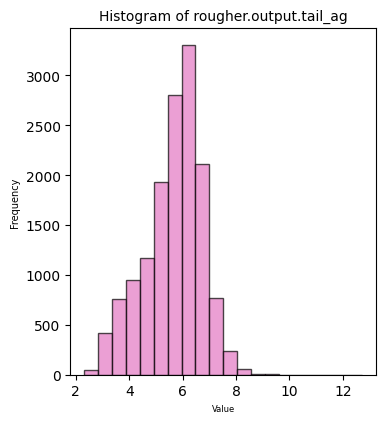

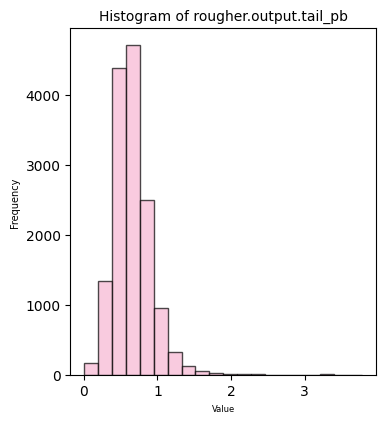

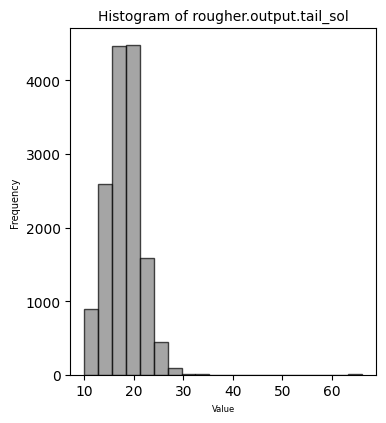

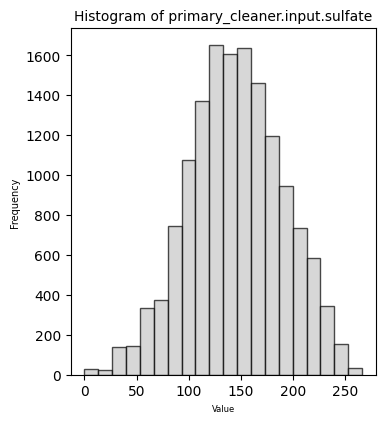

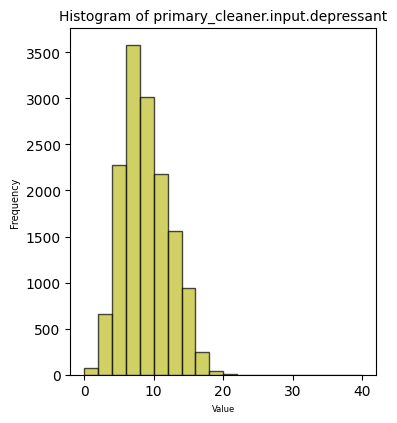

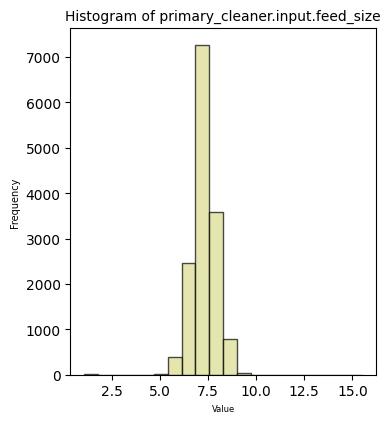

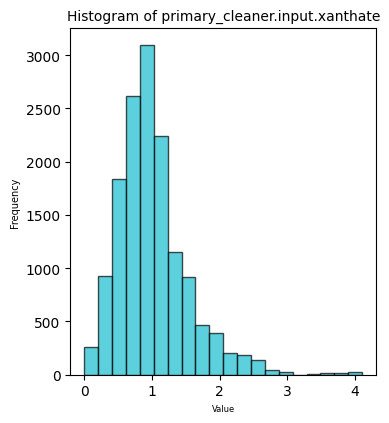

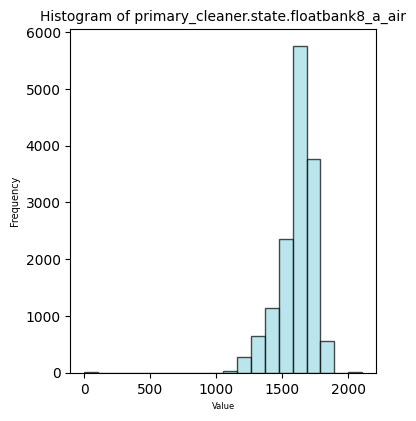

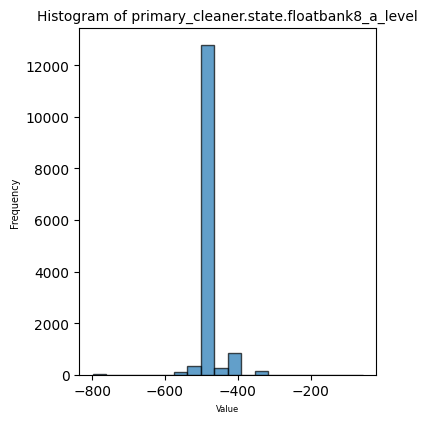

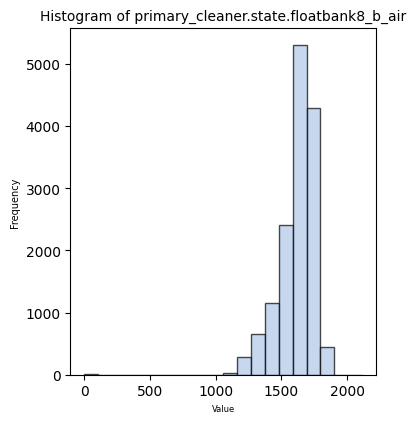

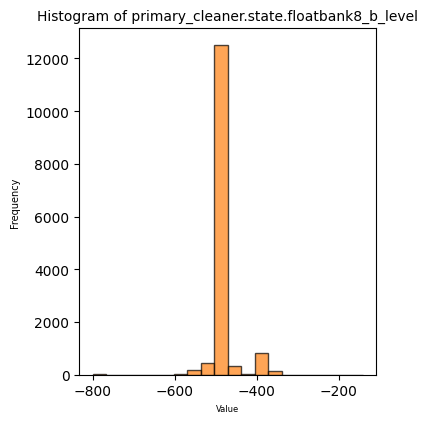

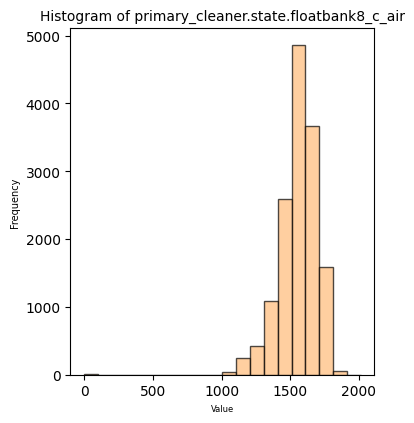

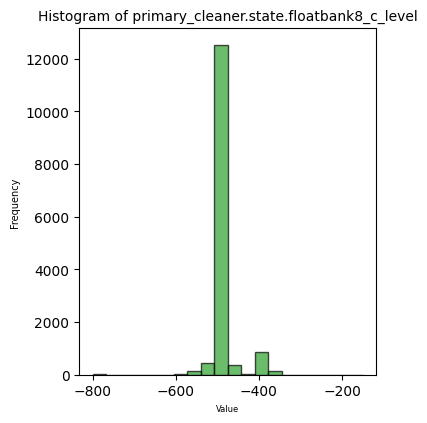

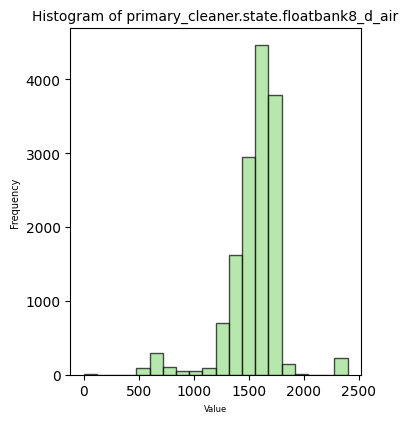

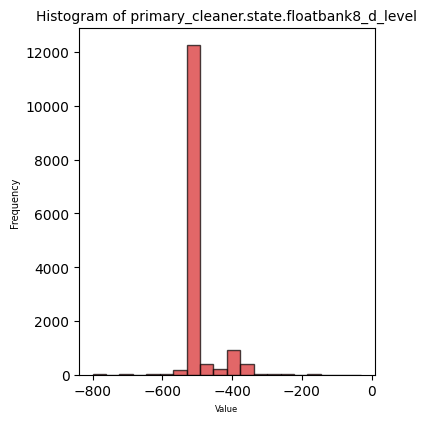

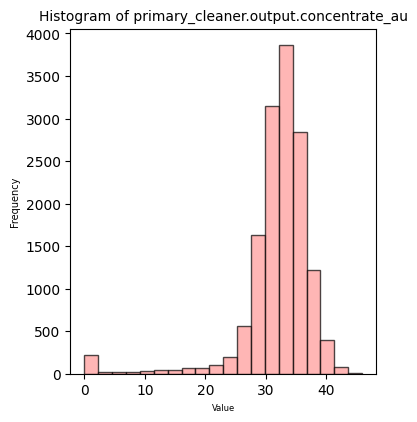

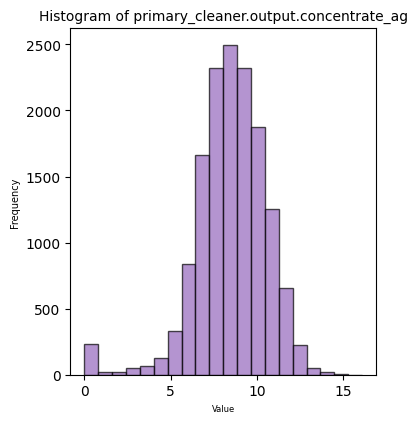

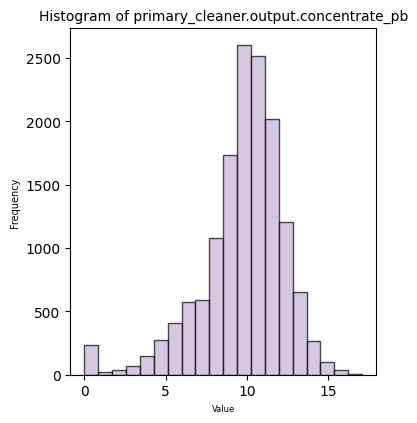

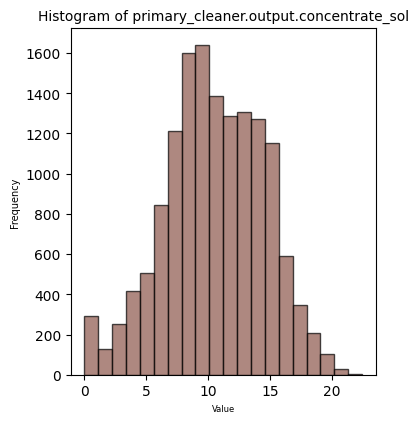

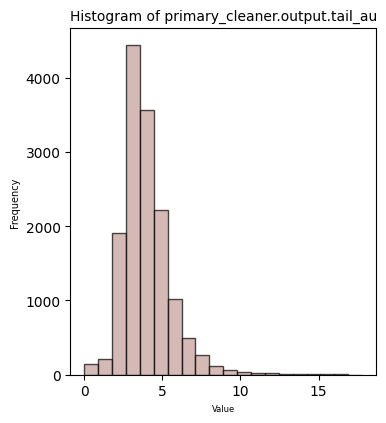

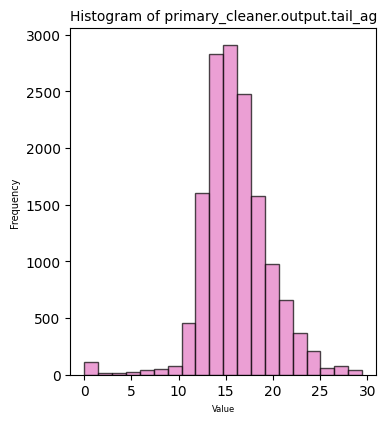

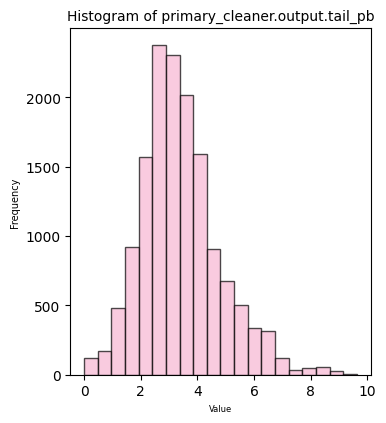

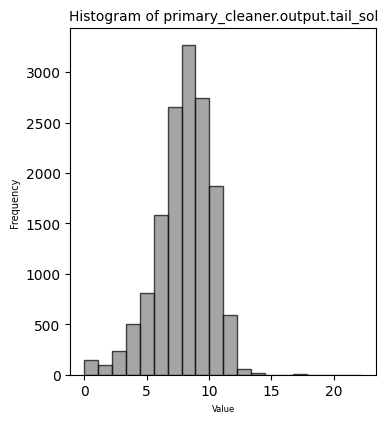

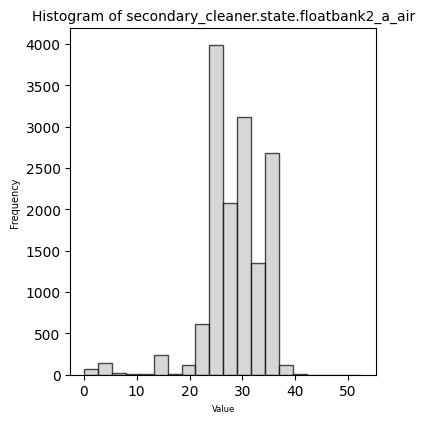

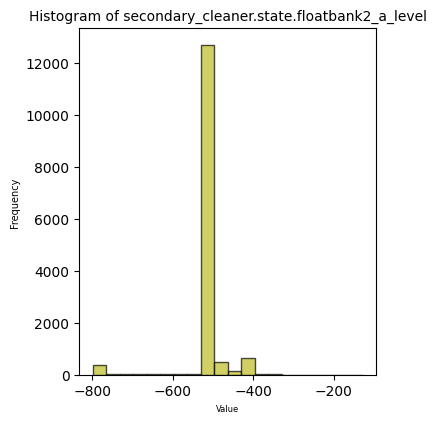

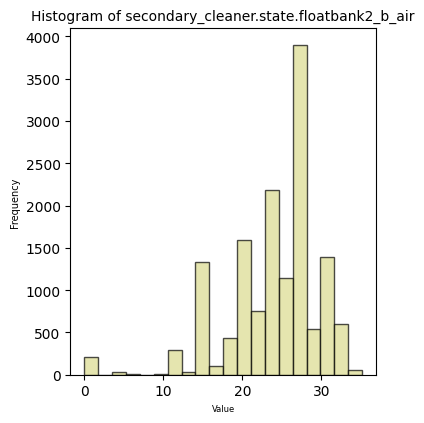

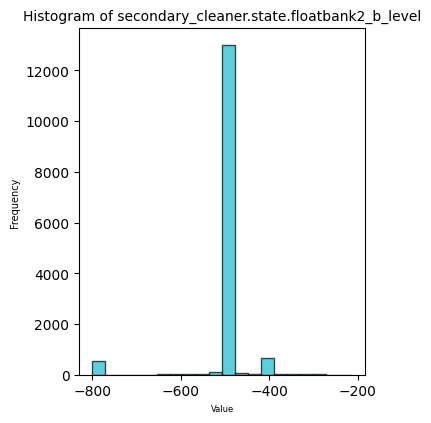

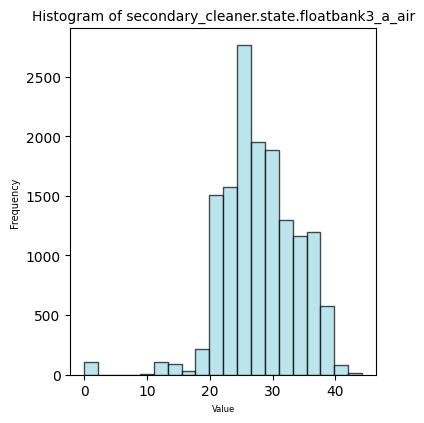

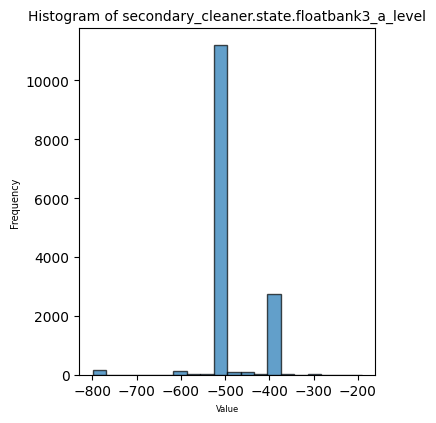

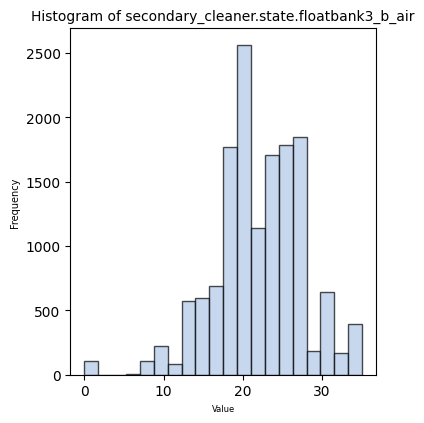

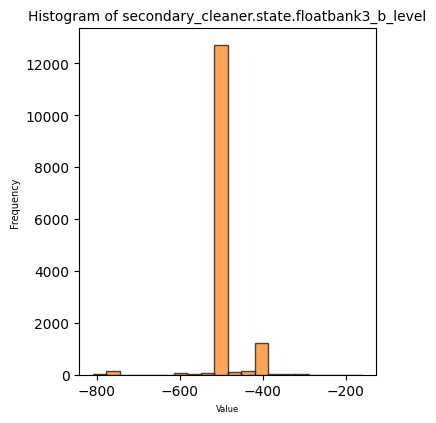

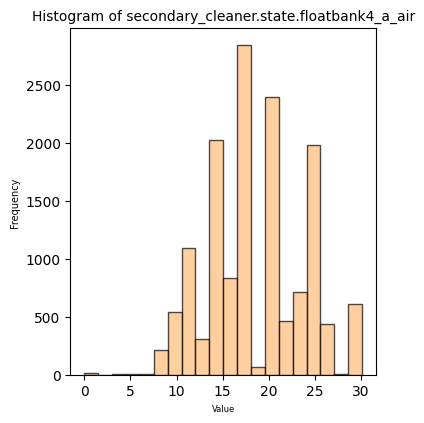

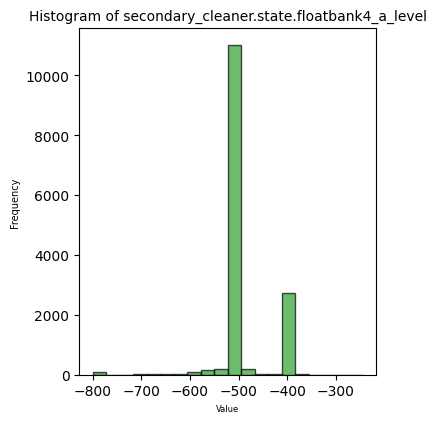

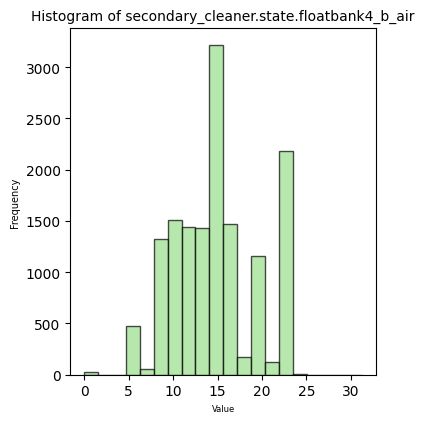

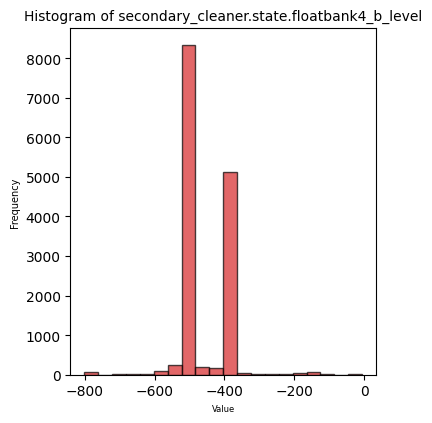

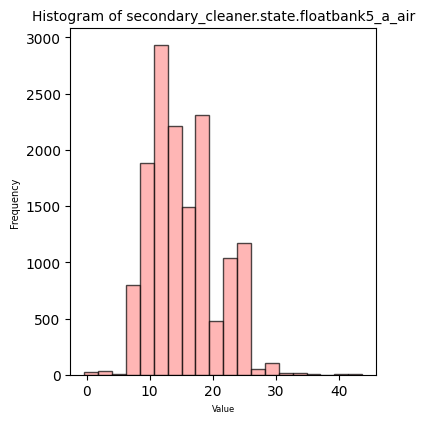

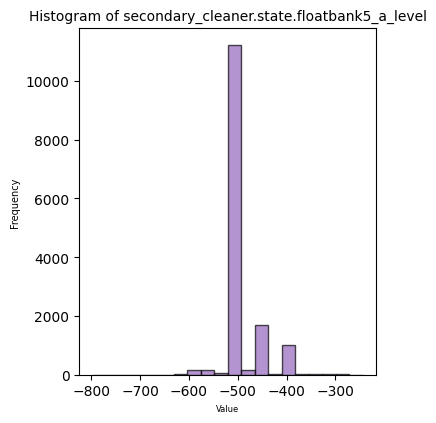

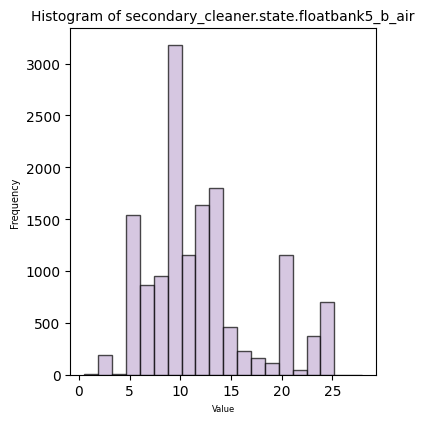

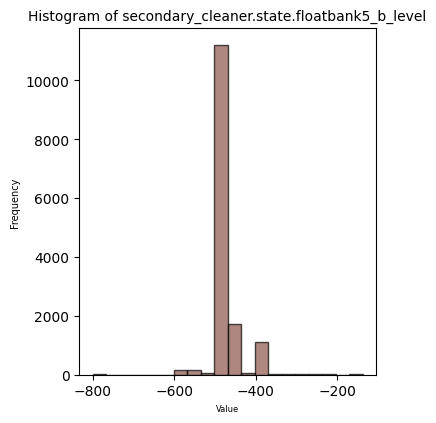

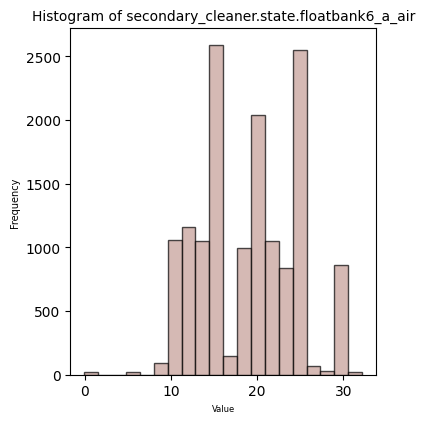

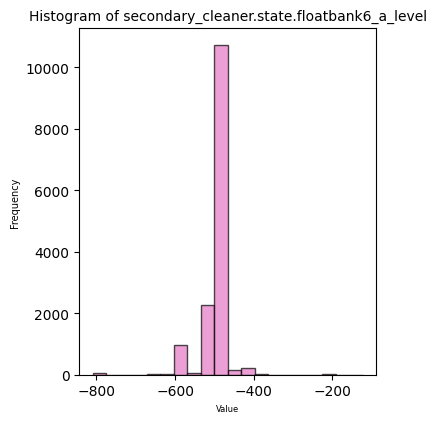

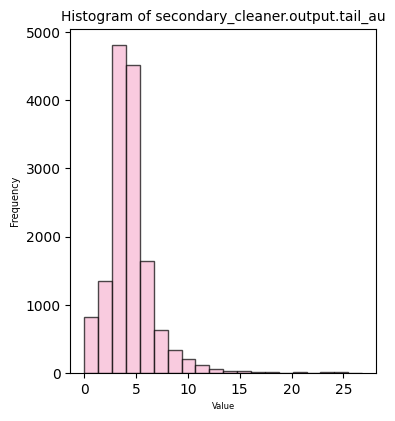

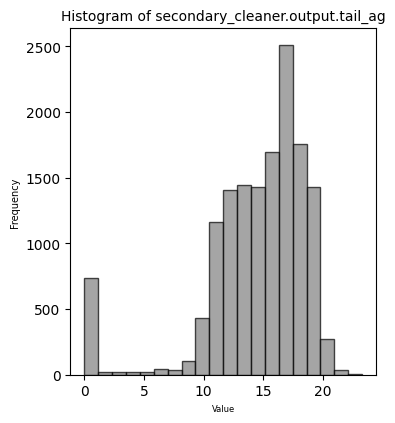

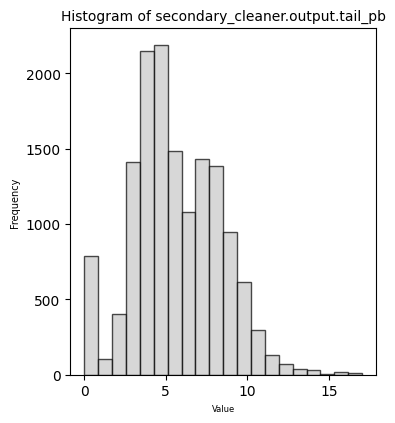

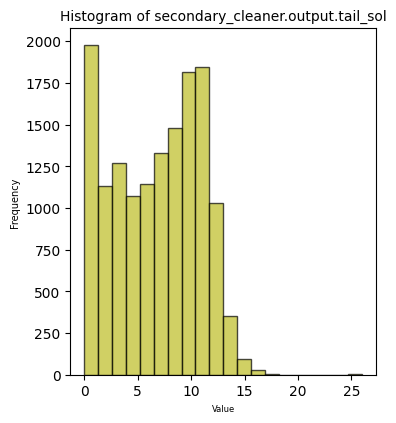

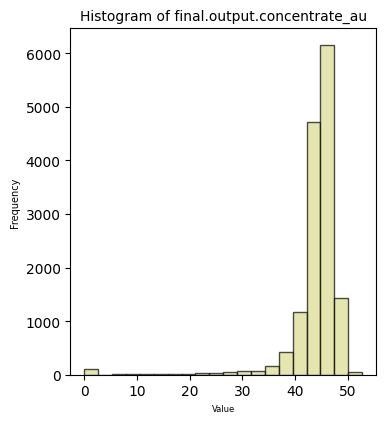

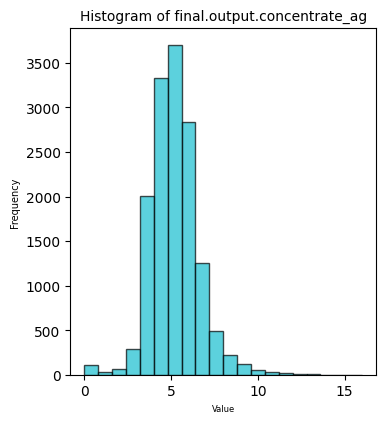

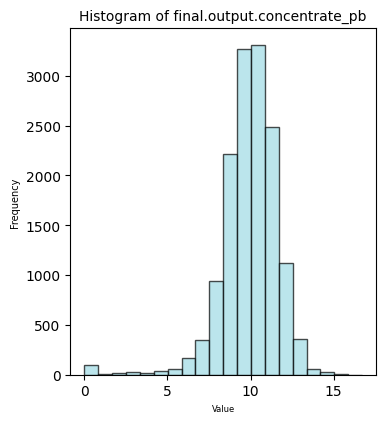

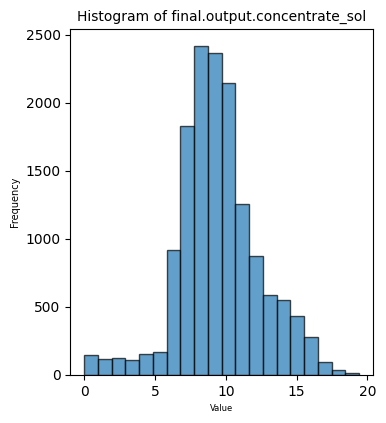

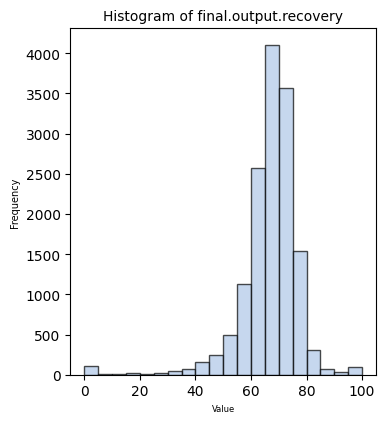

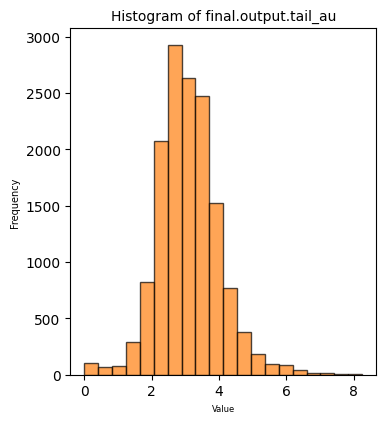

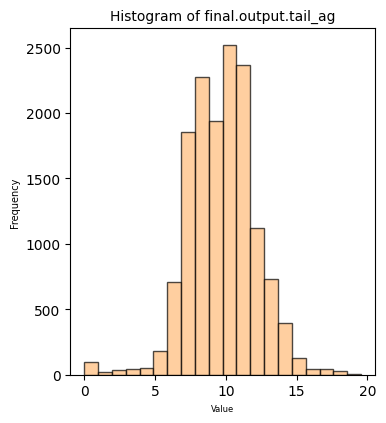

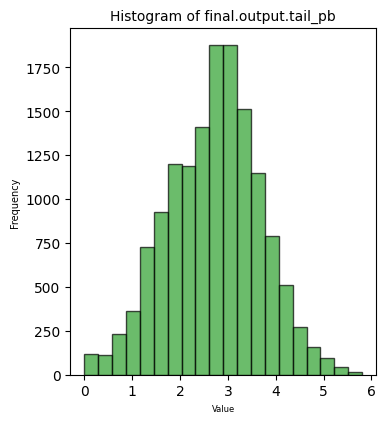

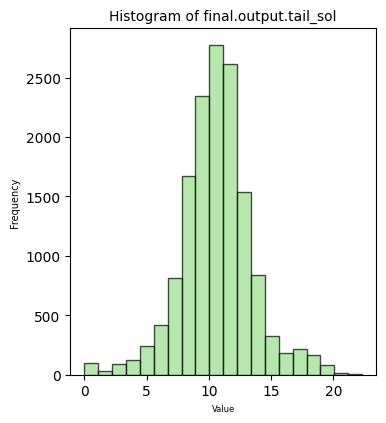

In [12]:
#Отобразим все параметры на гистограммах
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_train_t[col].plot.hist(bins=20, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

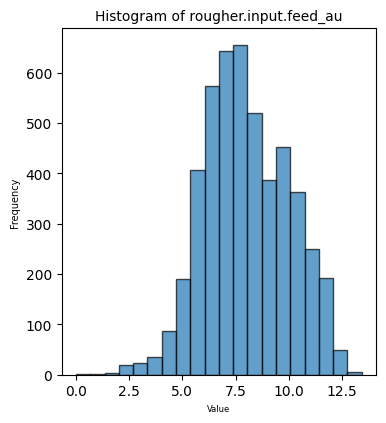

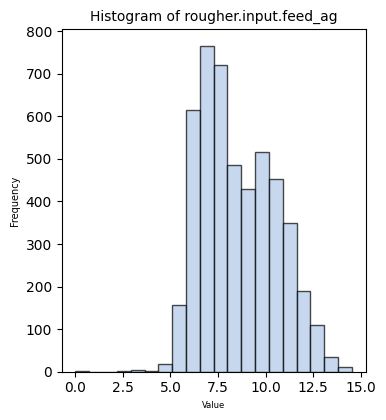

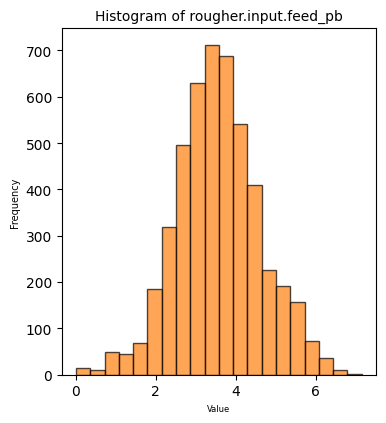

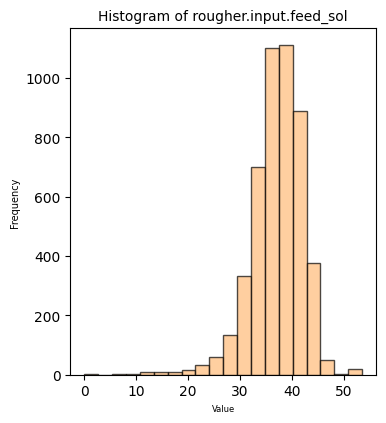

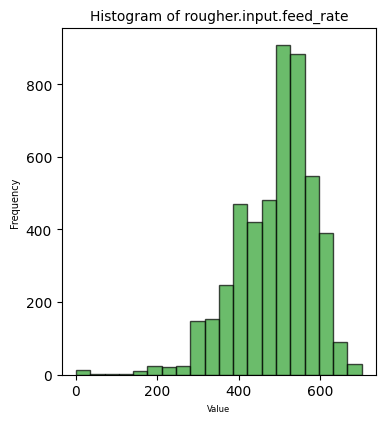

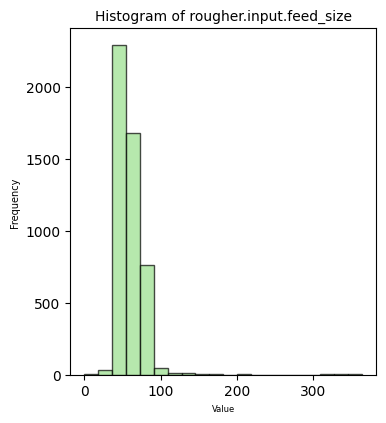

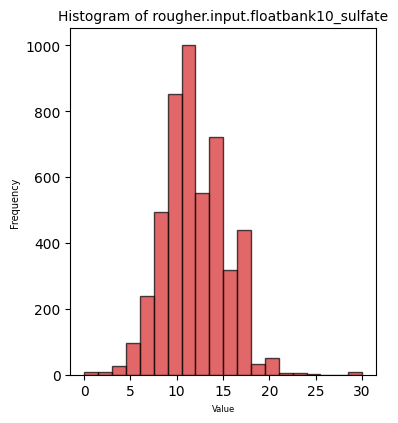

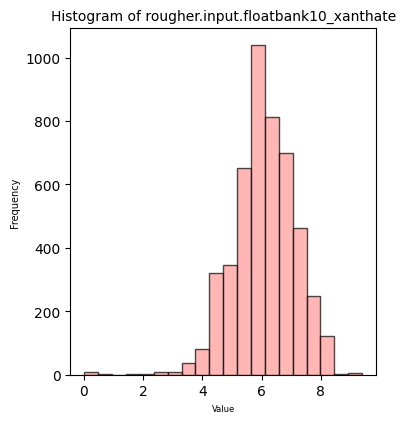

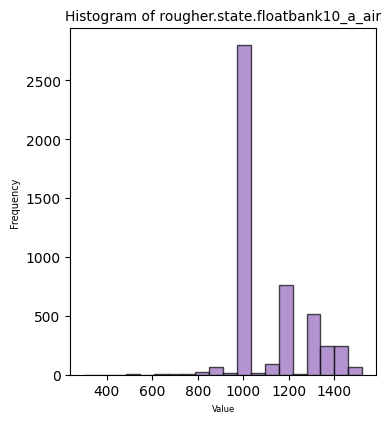

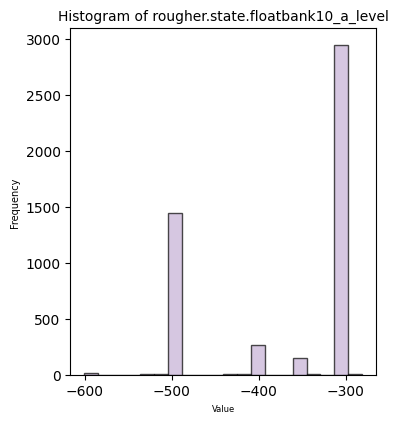

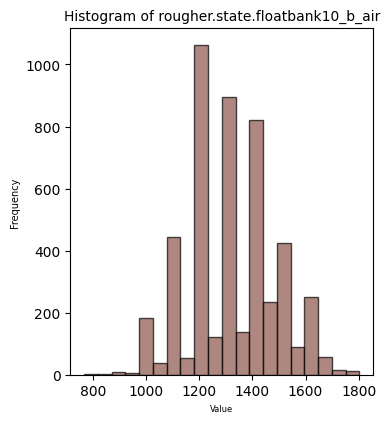

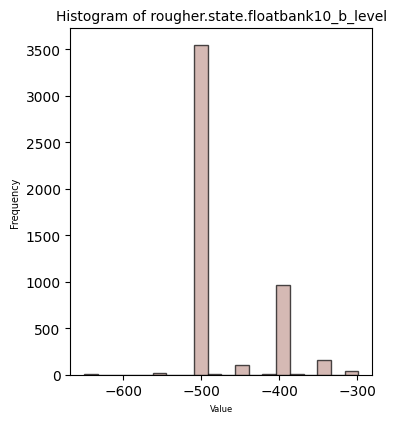

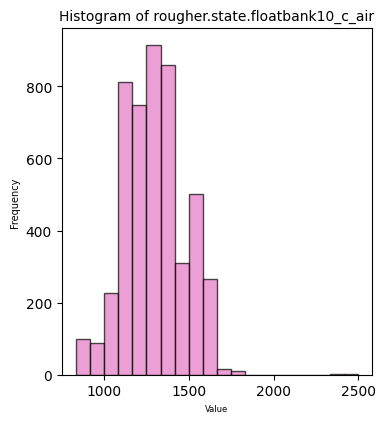

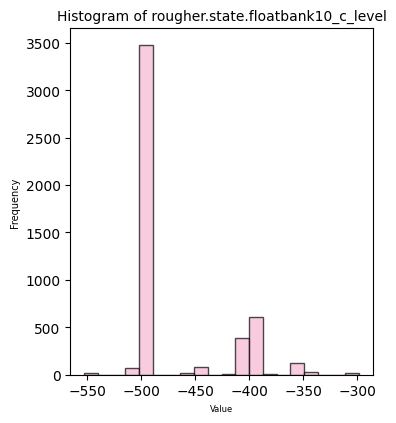

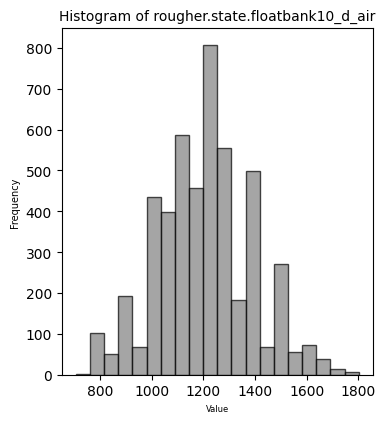

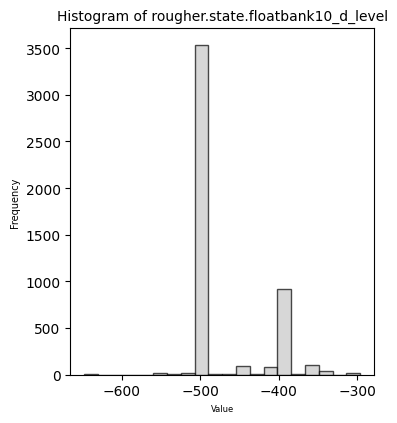

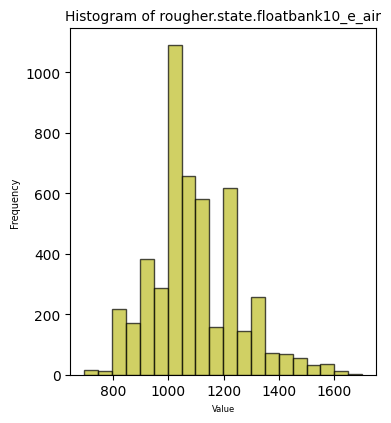

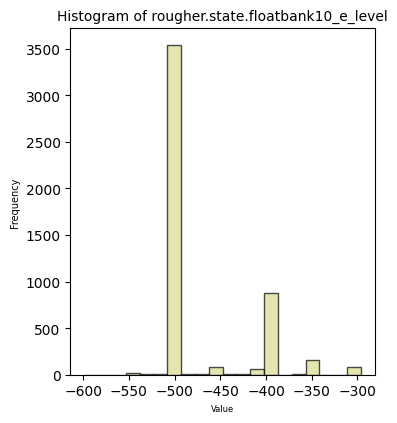

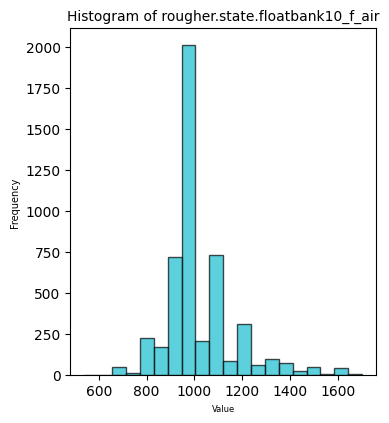

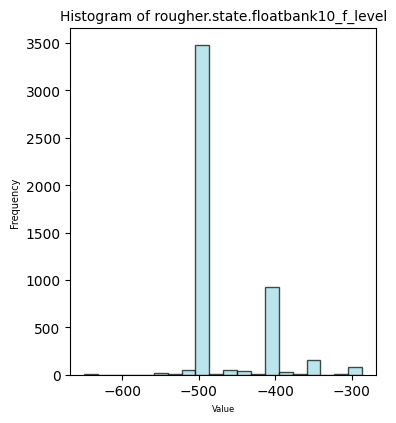

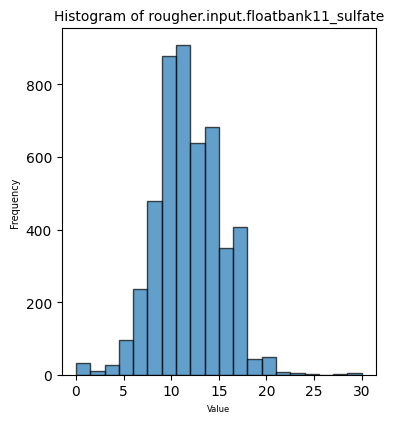

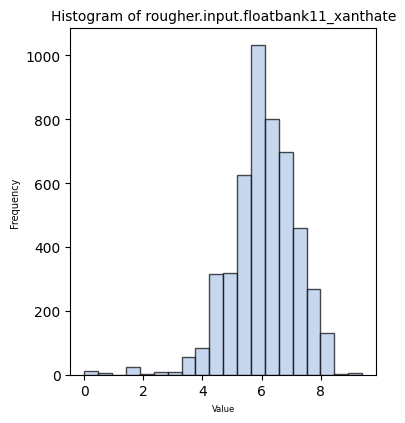

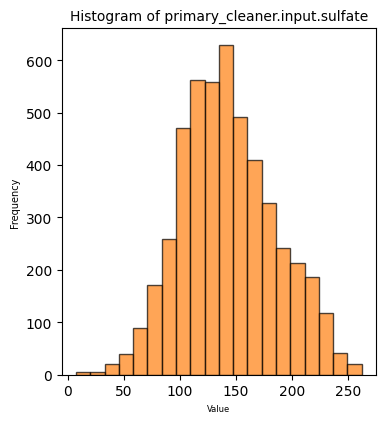

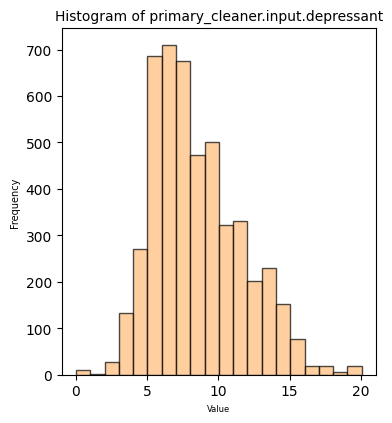

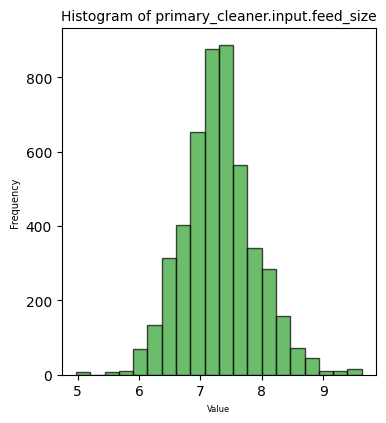

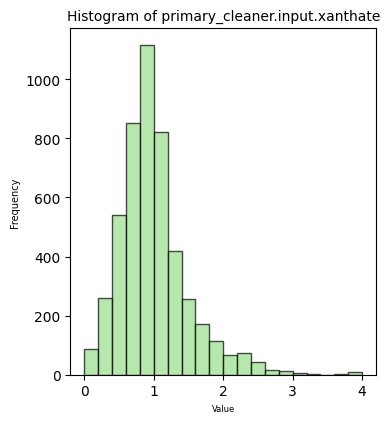

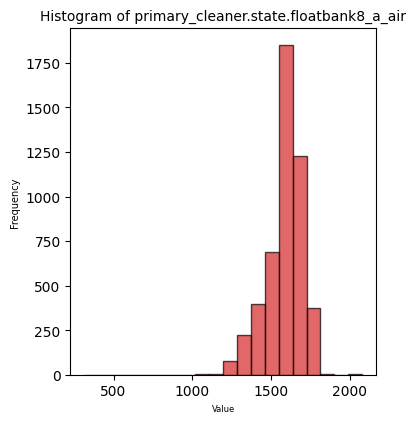

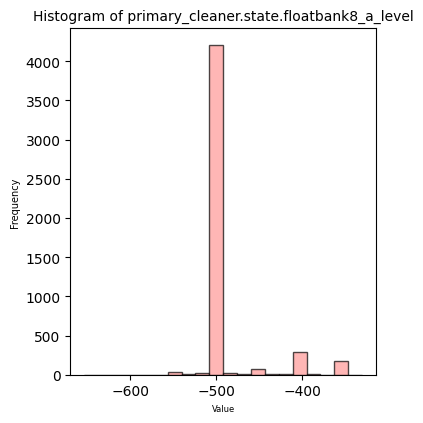

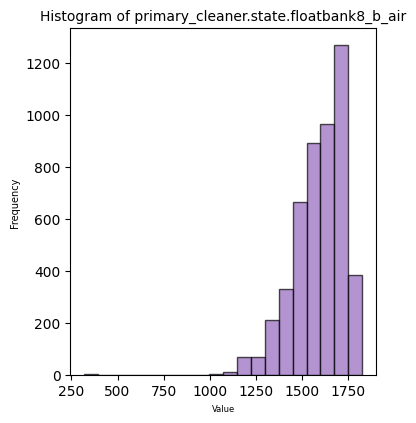

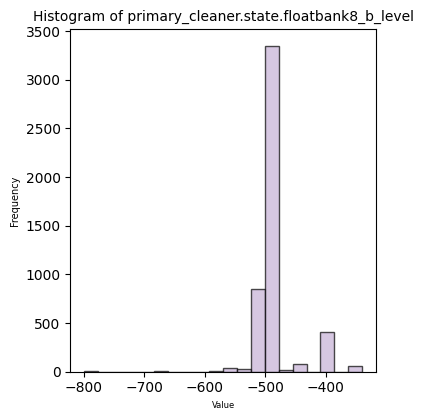

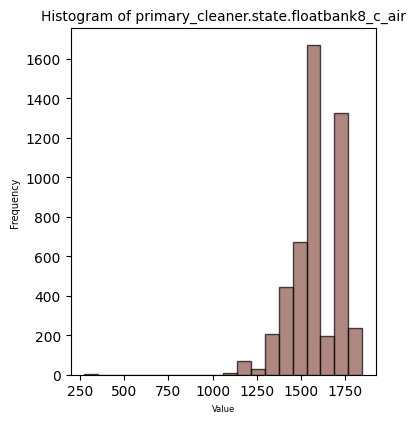

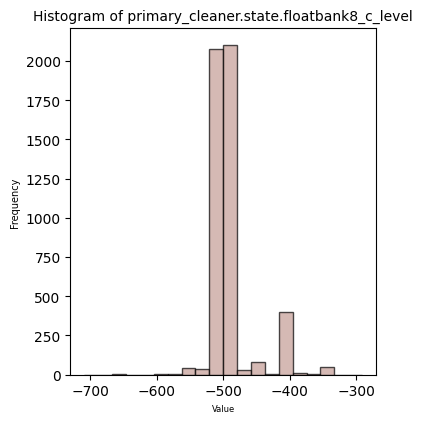

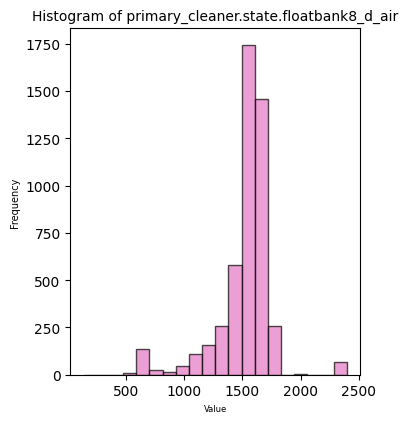

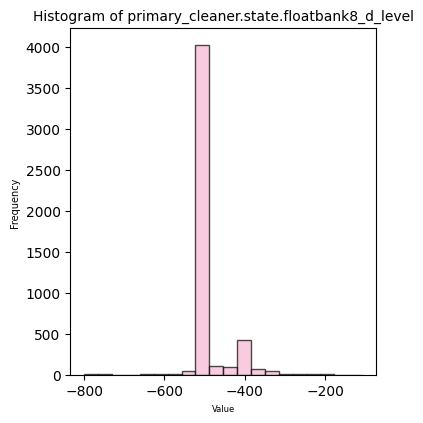

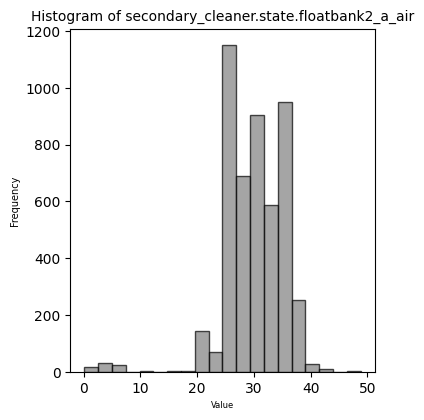

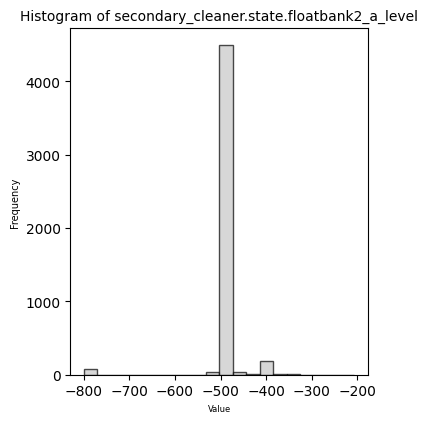

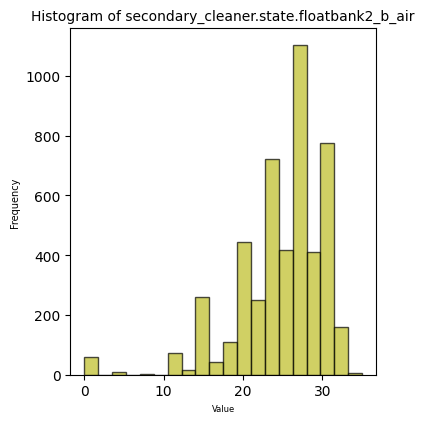

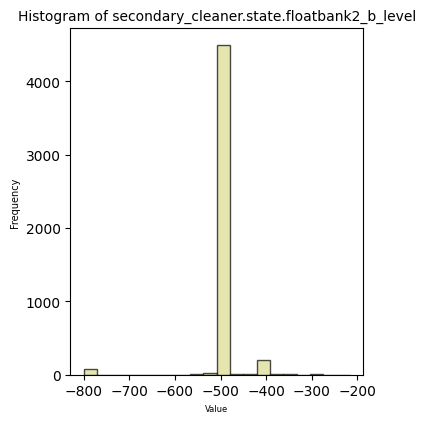

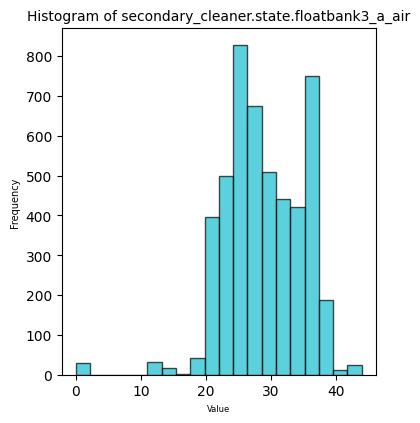

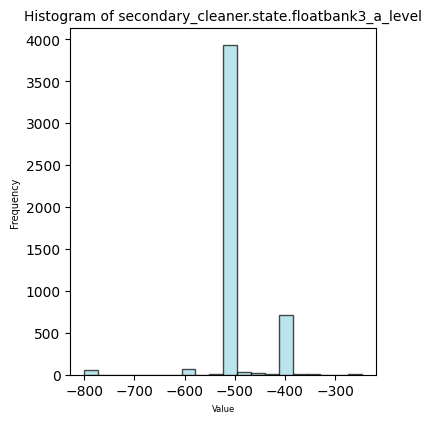

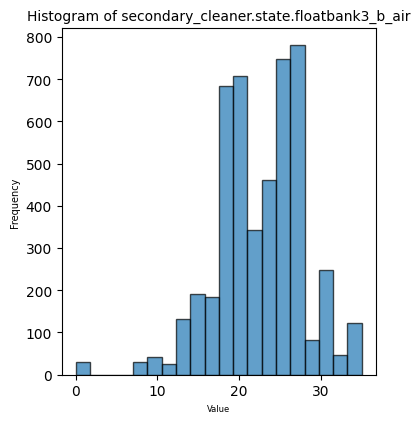

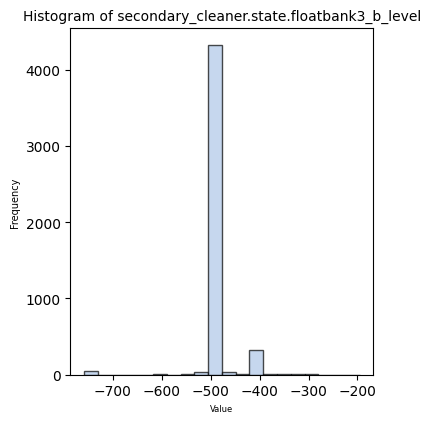

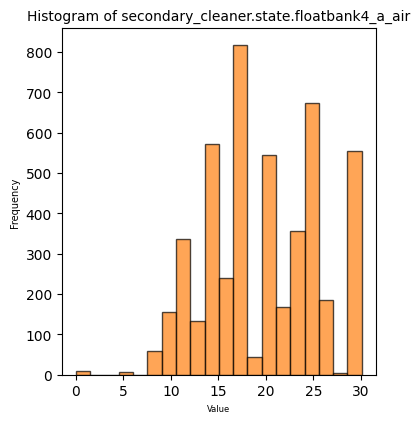

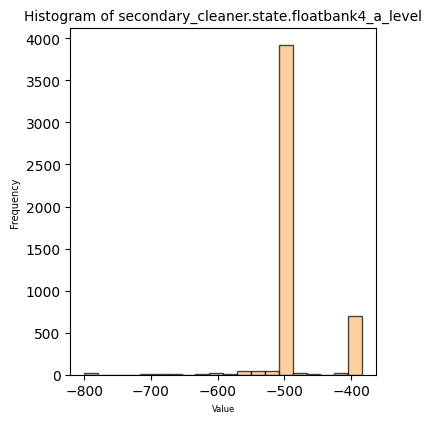

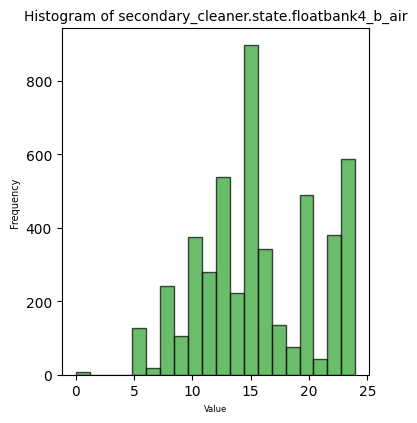

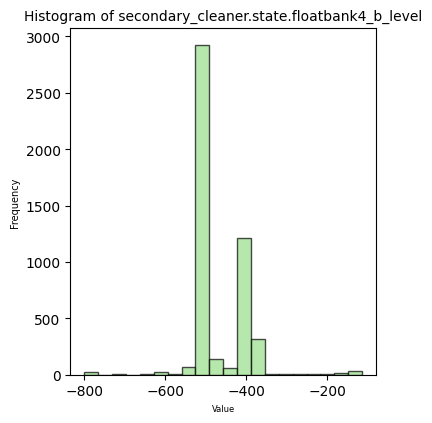

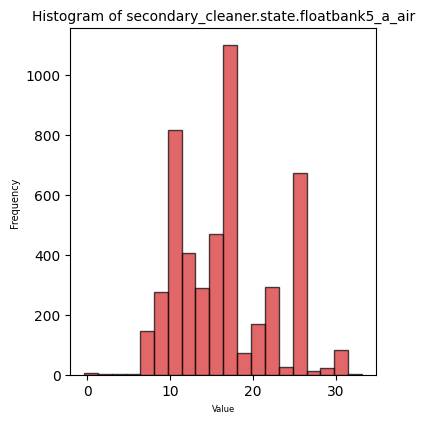

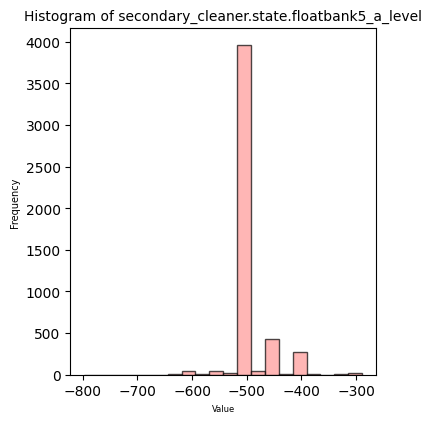

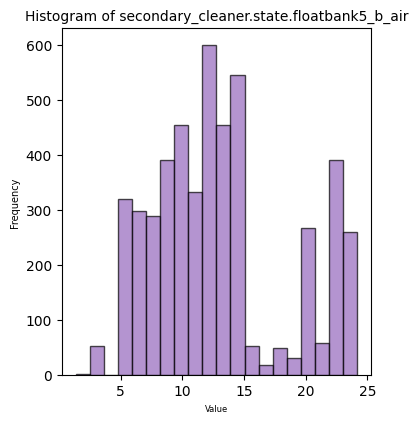

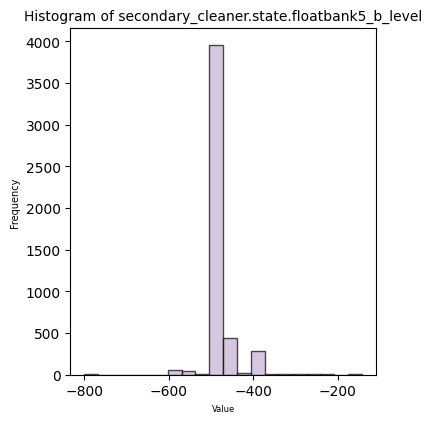

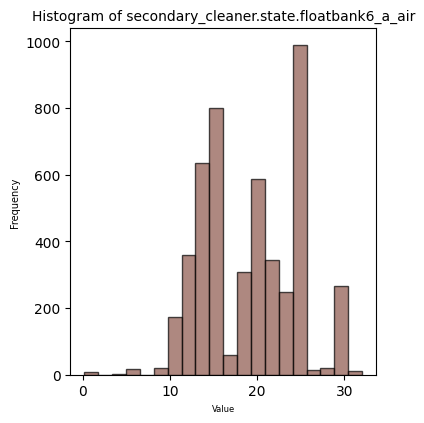

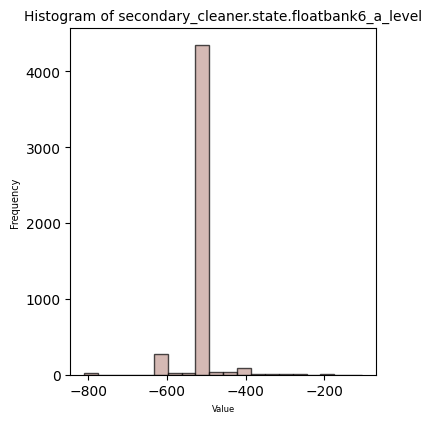

In [13]:
#Отобразим все параметры на гистограммах
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
for i, col in enumerate(column_test):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_test_t[col].plot.hist(bins=20, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

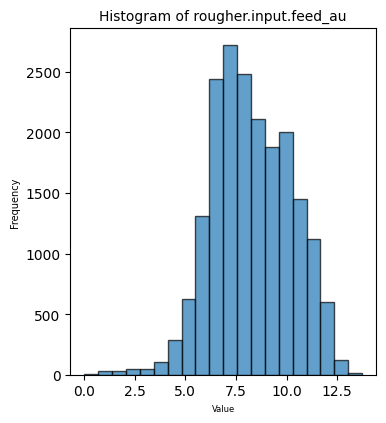

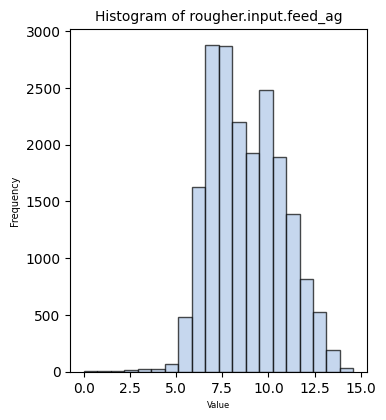

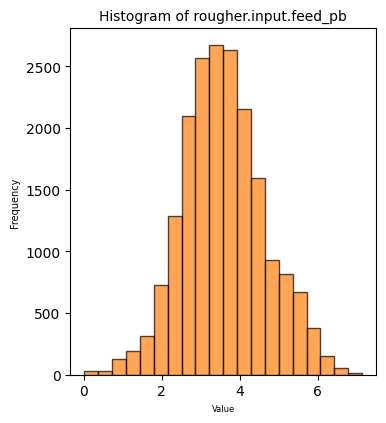

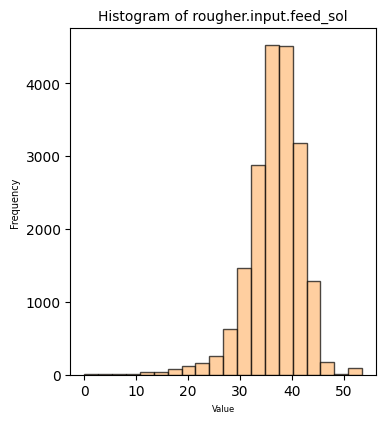

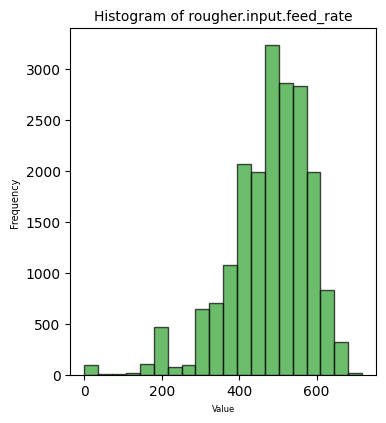

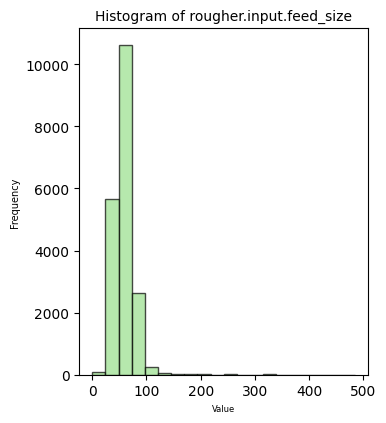

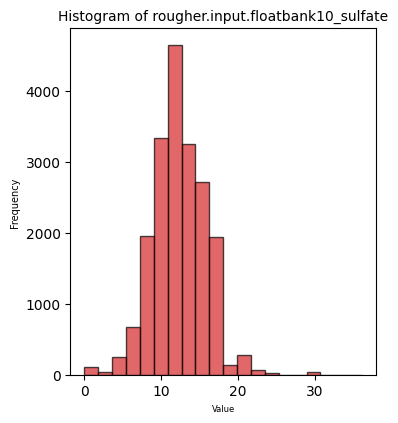

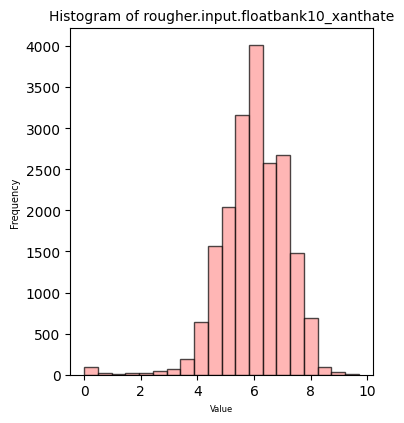

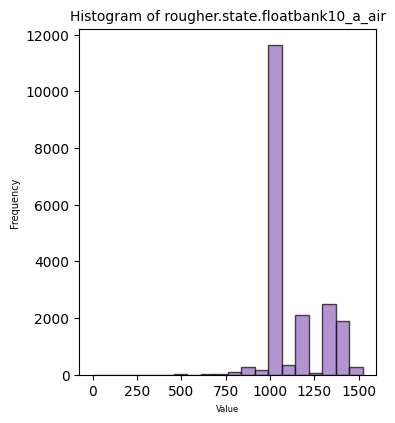

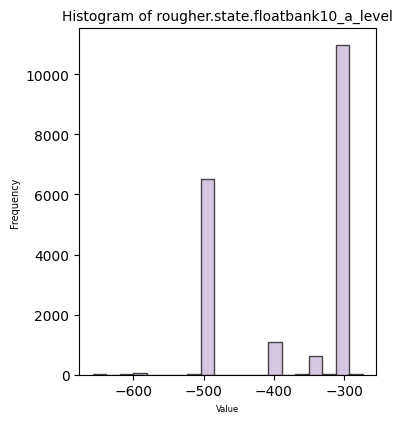

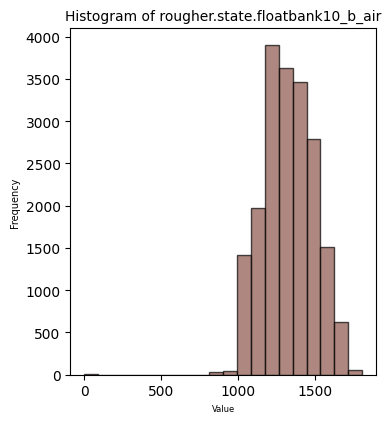

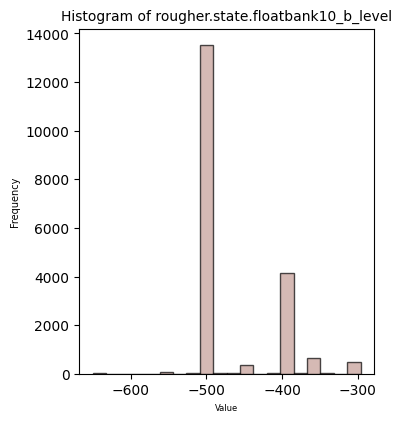

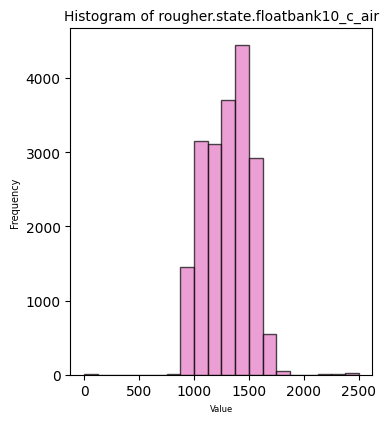

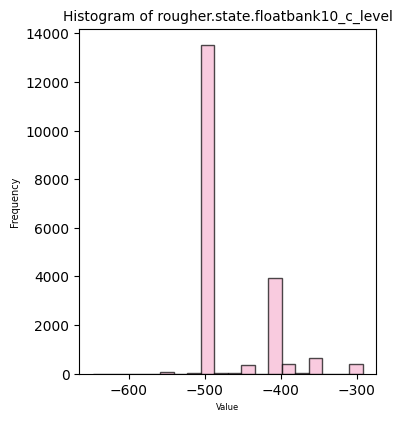

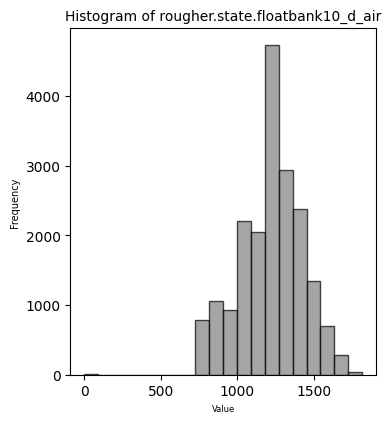

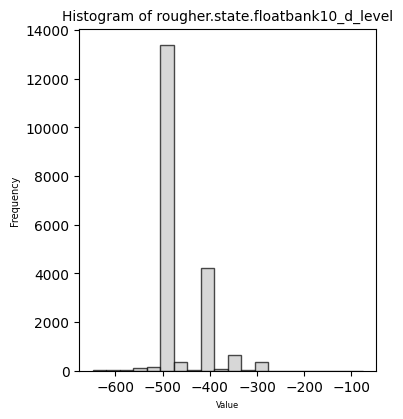

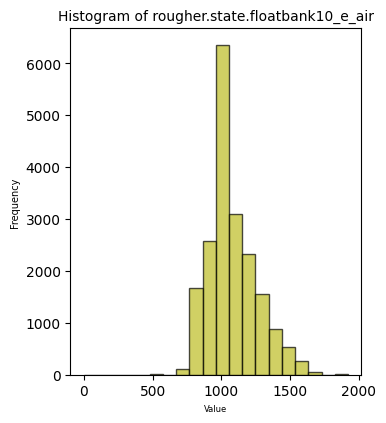

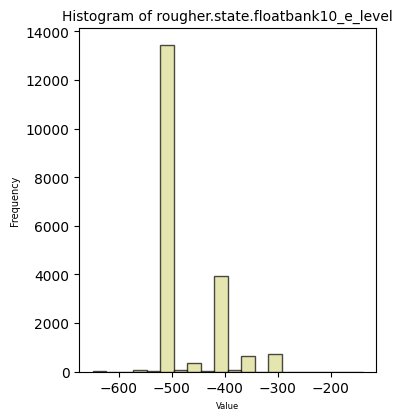

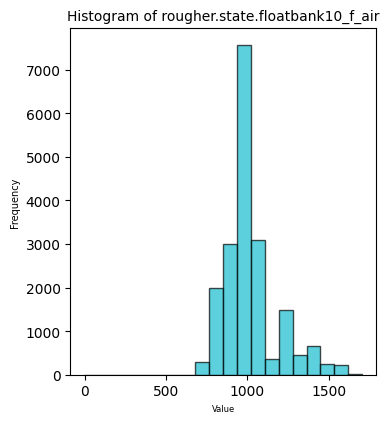

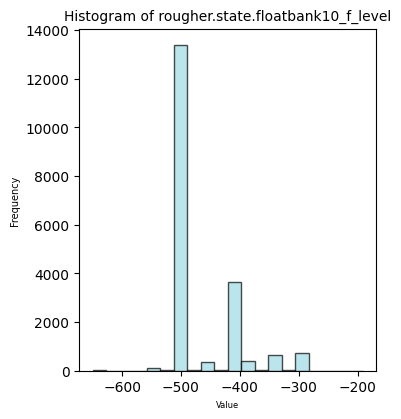

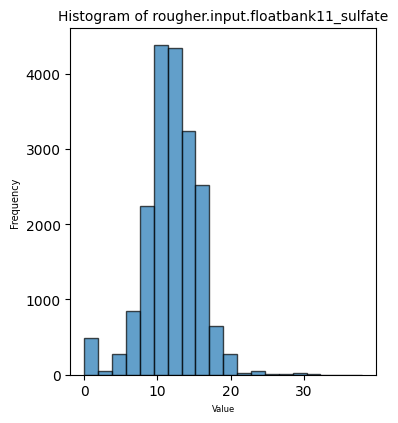

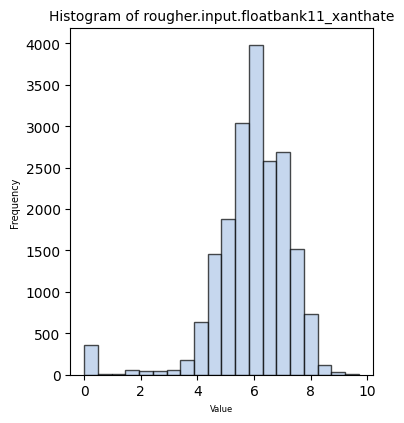

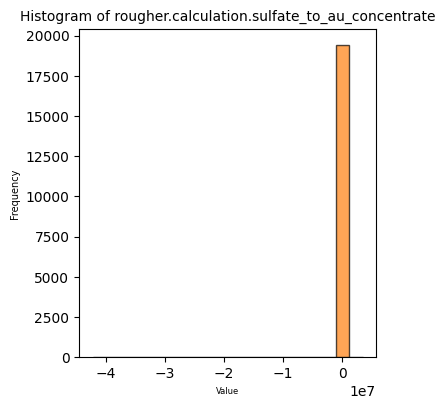

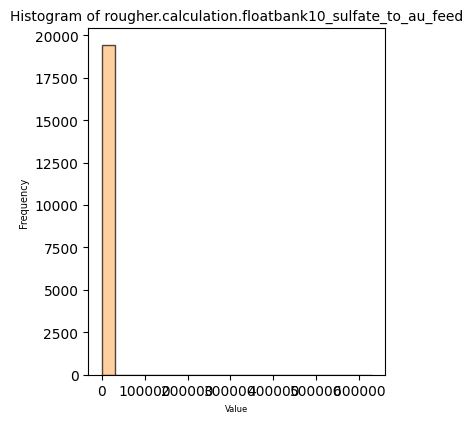

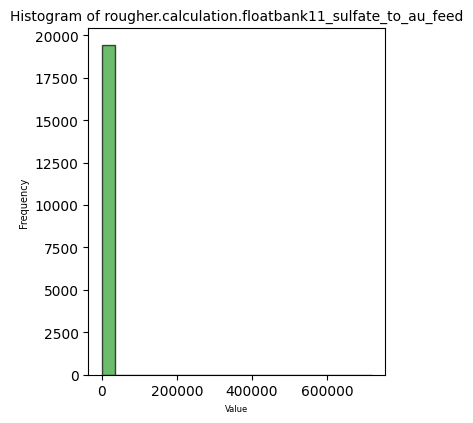

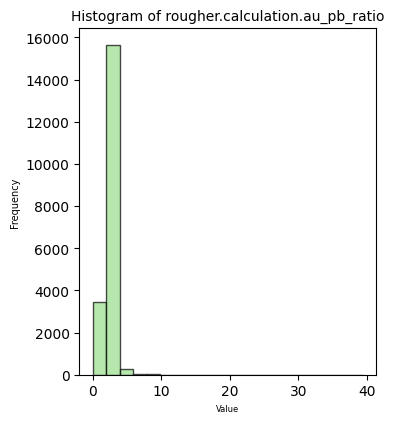

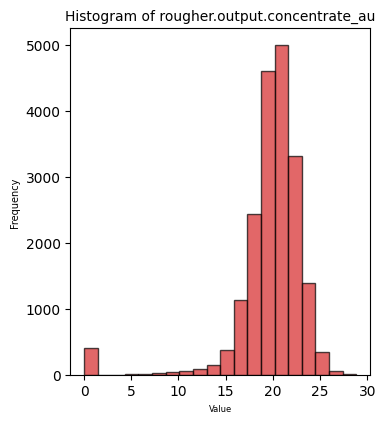

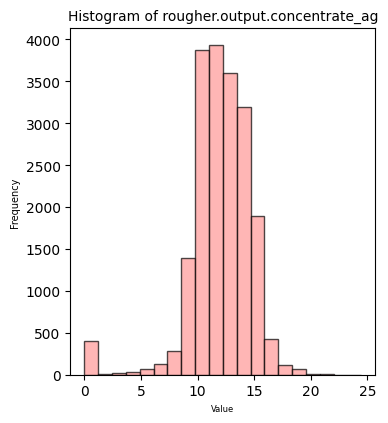

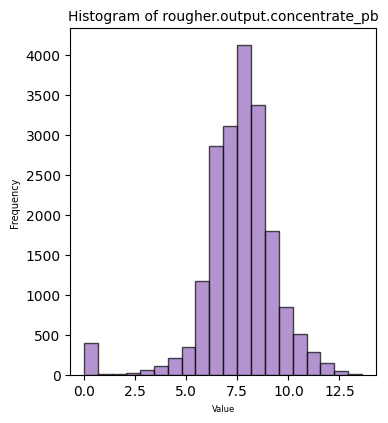

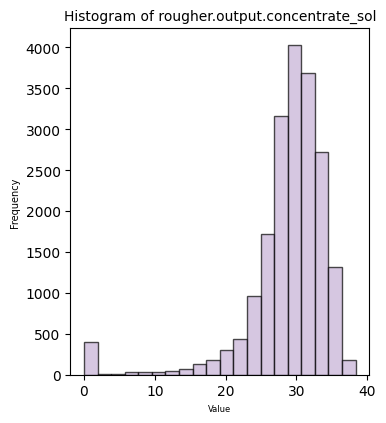

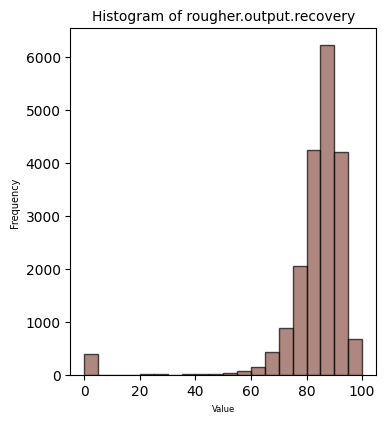

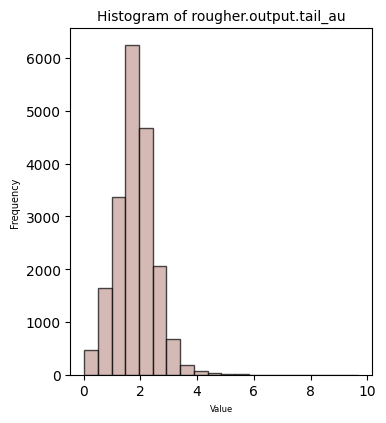

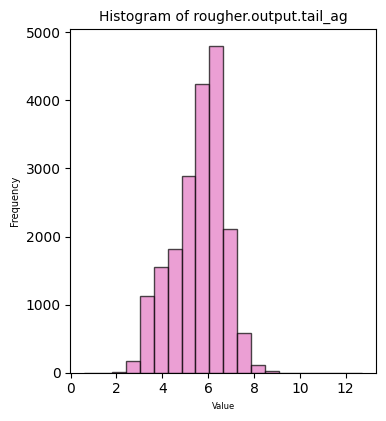

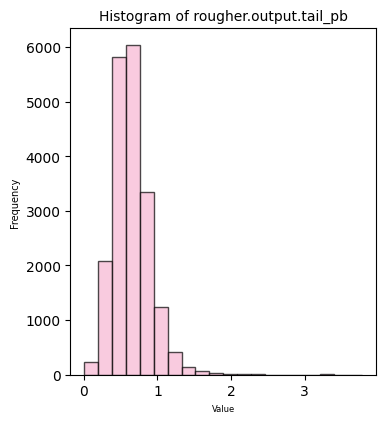

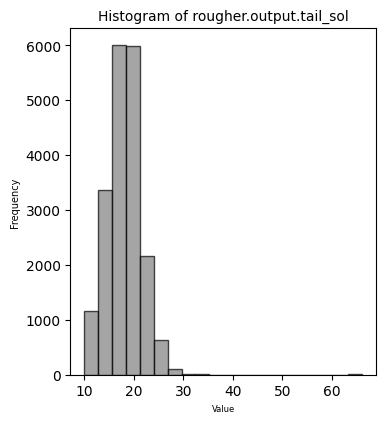

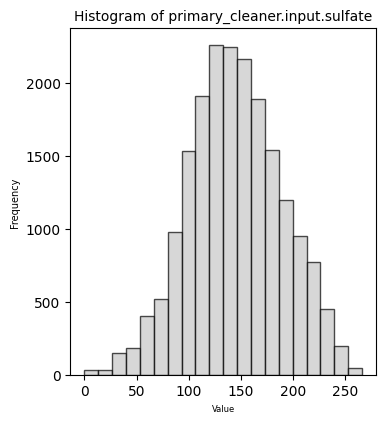

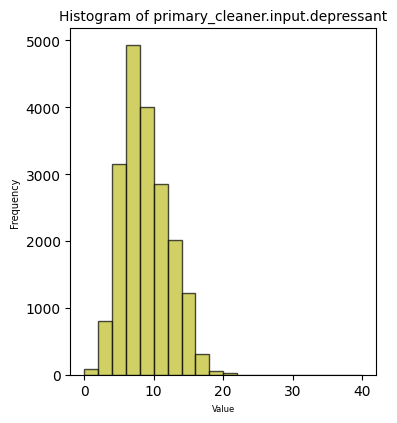

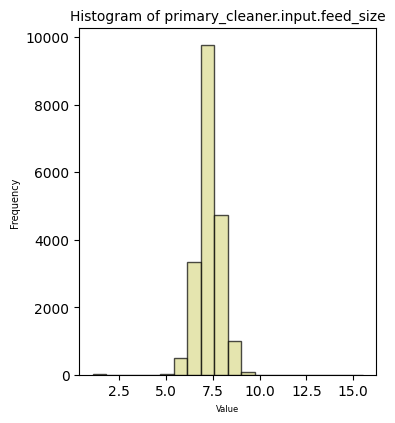

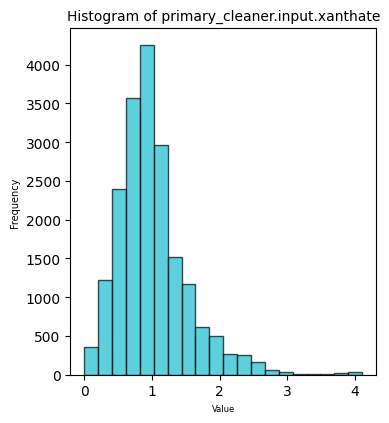

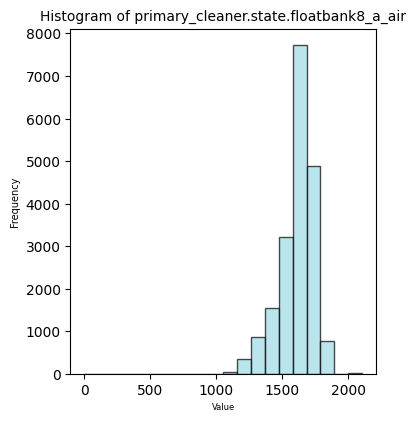

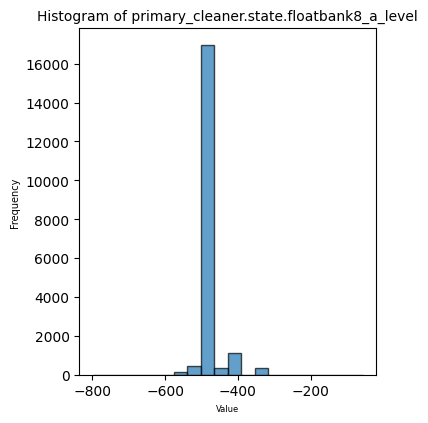

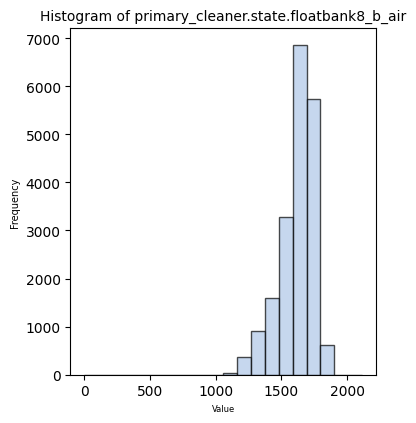

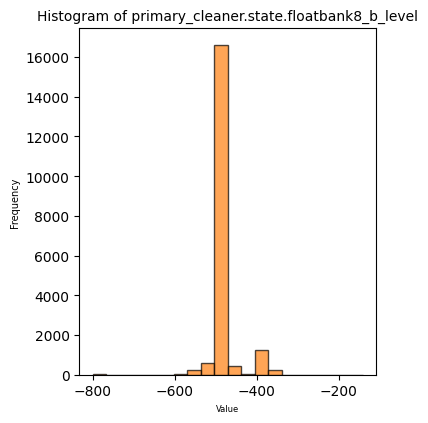

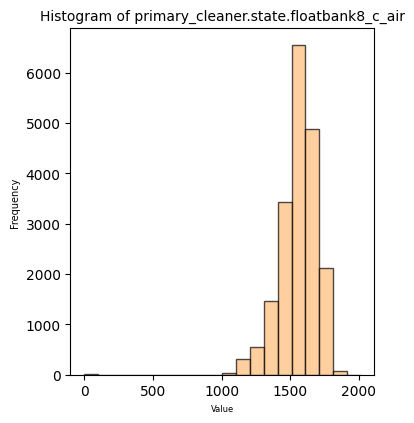

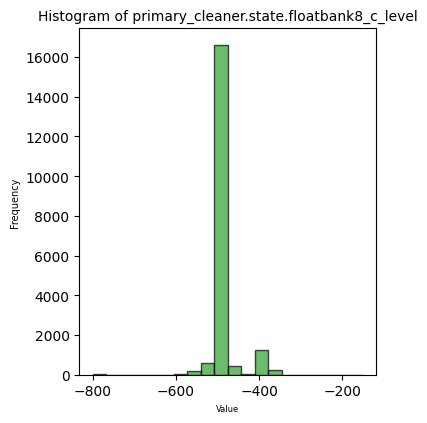

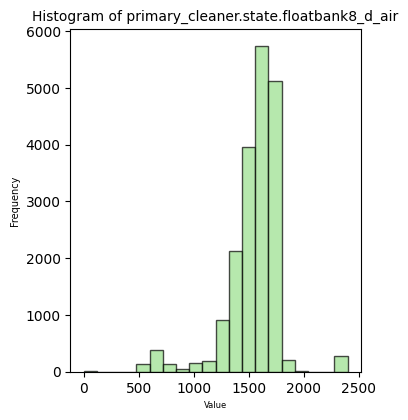

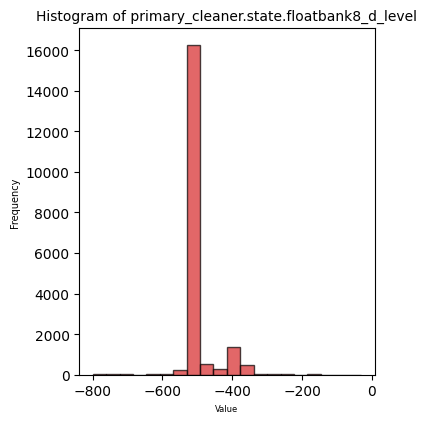

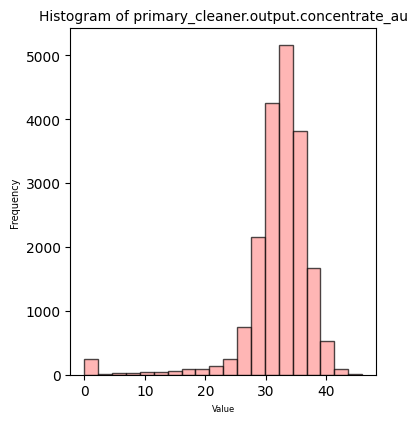

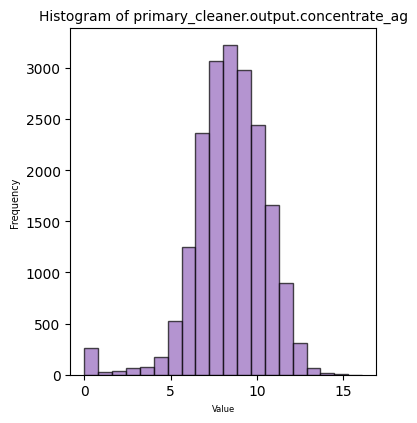

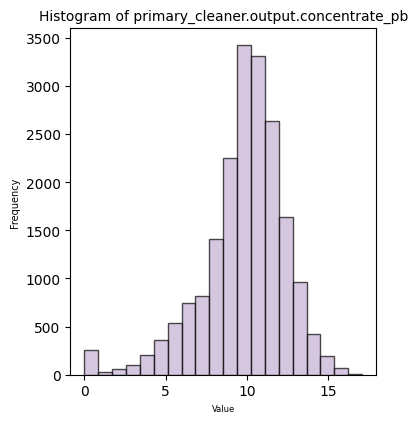

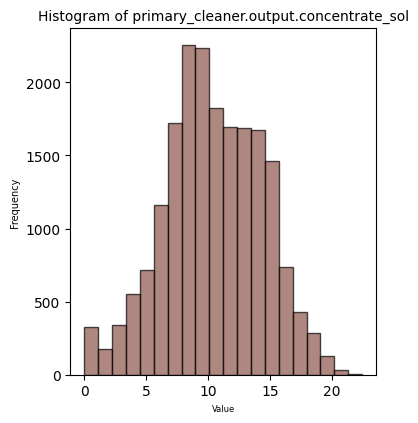

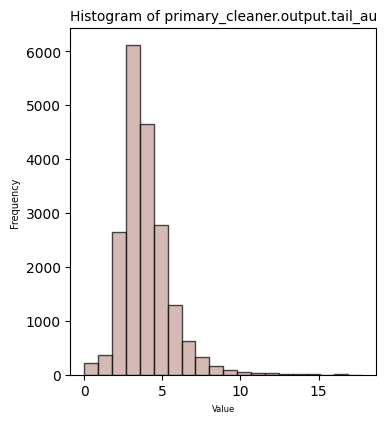

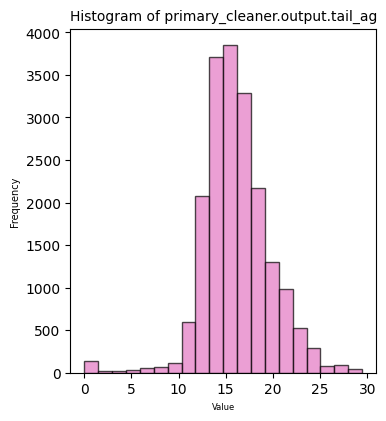

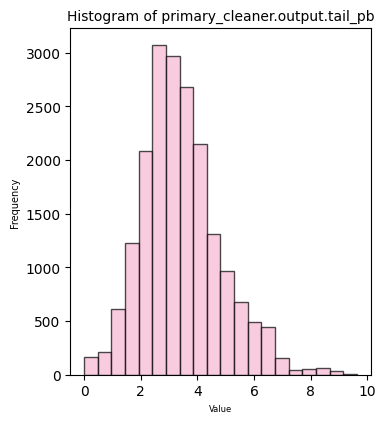

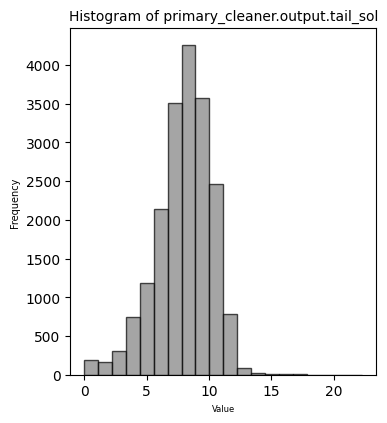

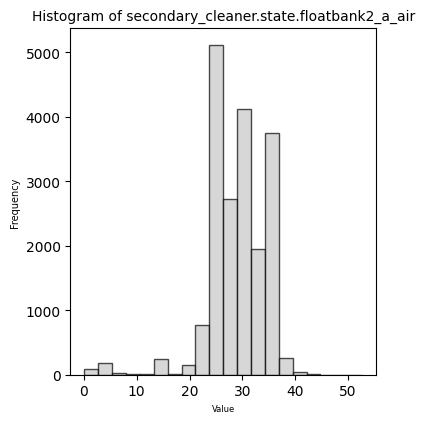

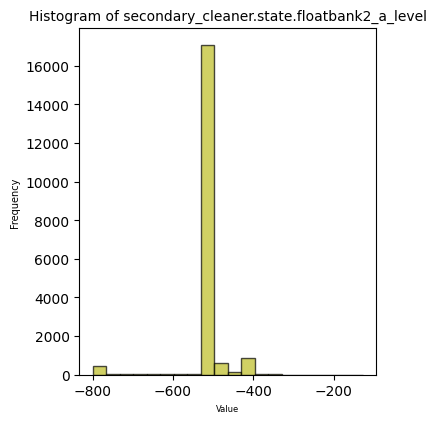

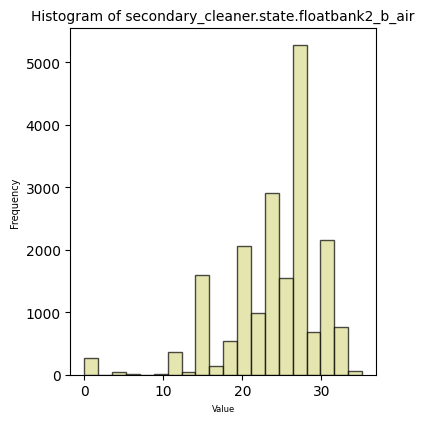

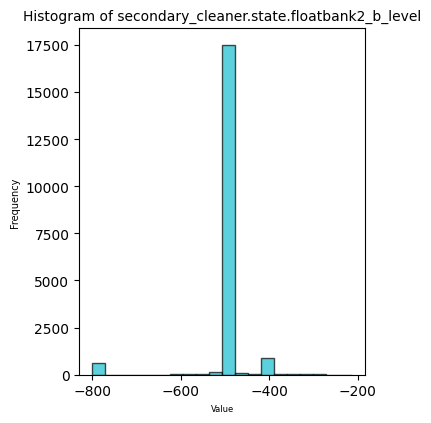

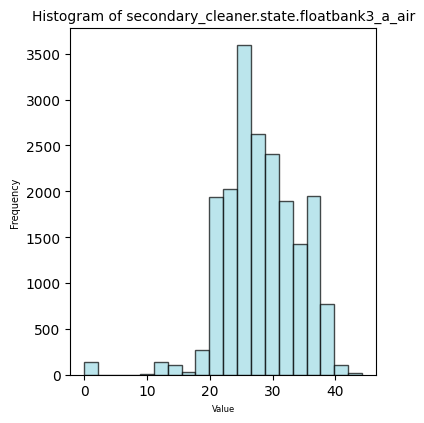

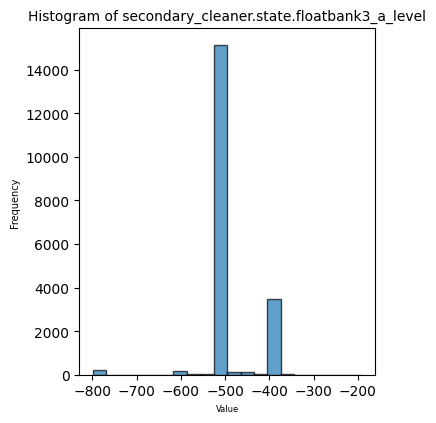

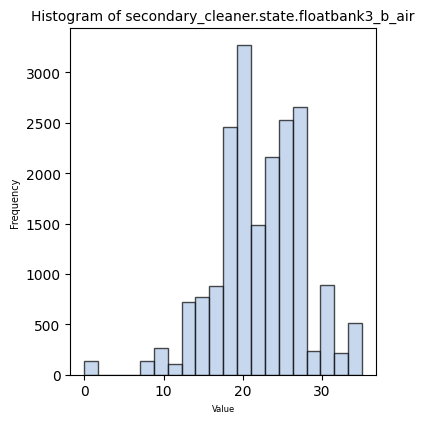

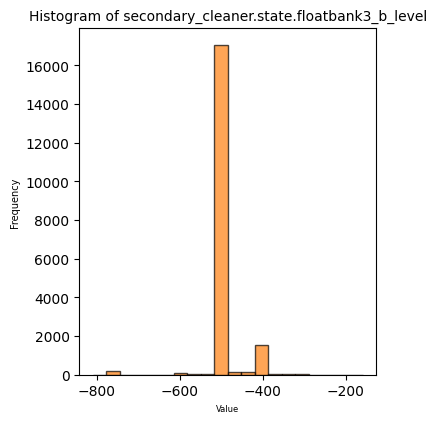

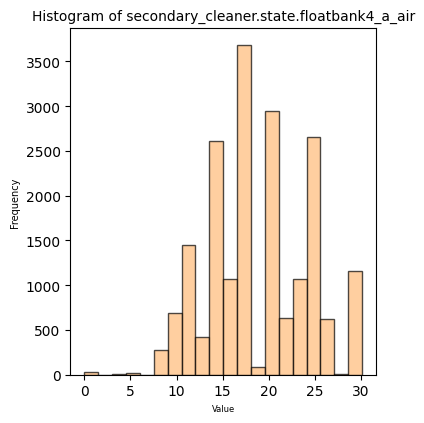

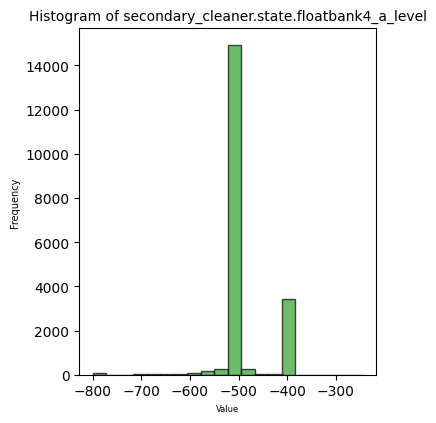

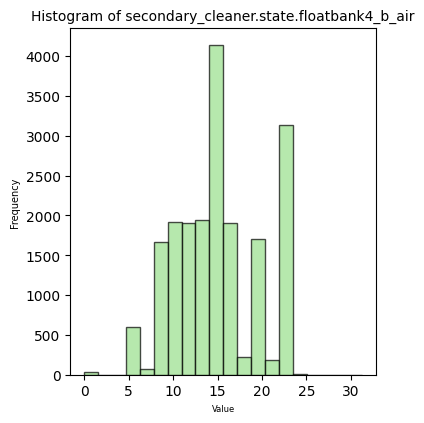

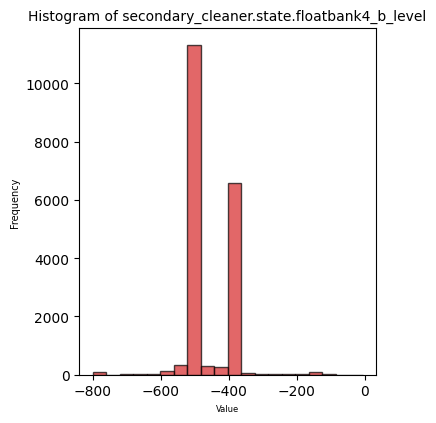

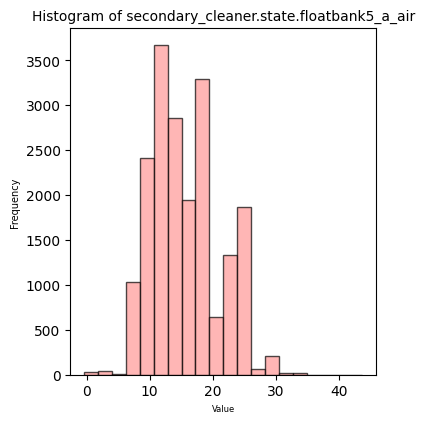

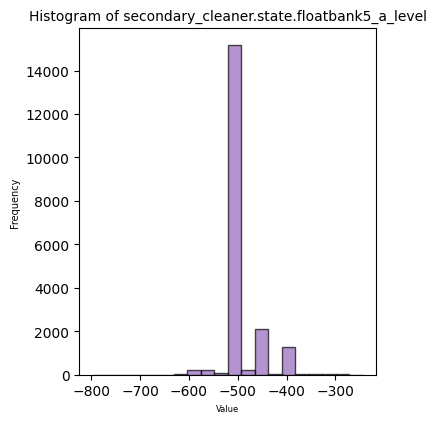

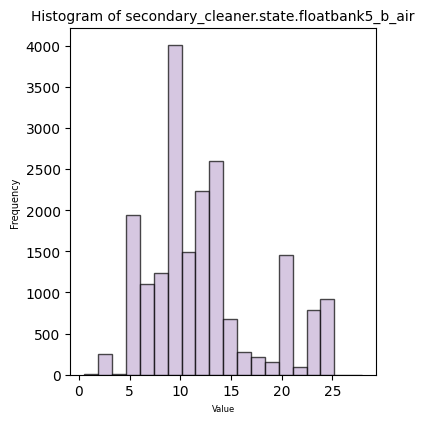

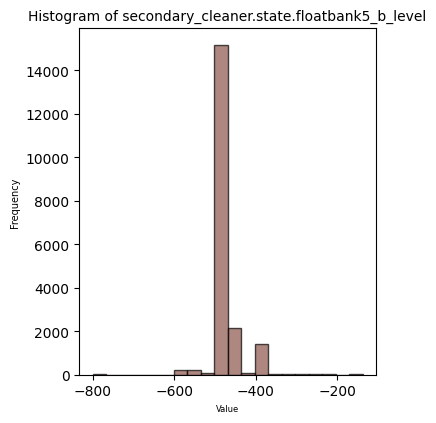

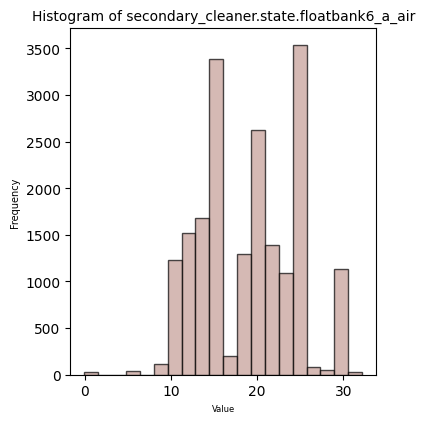

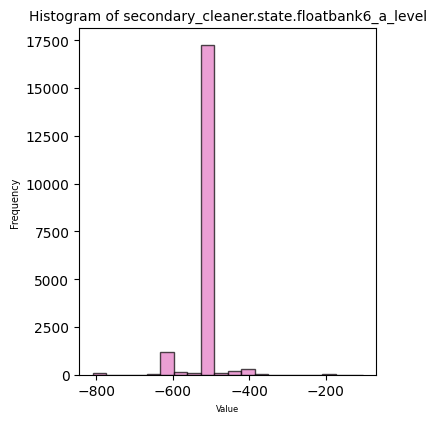

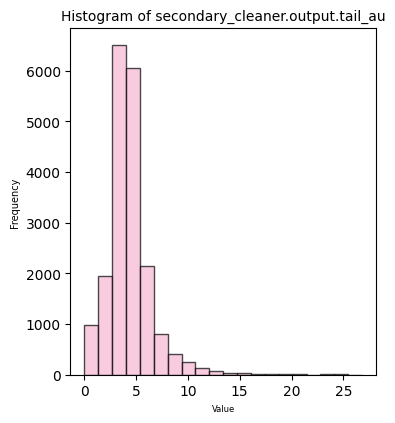

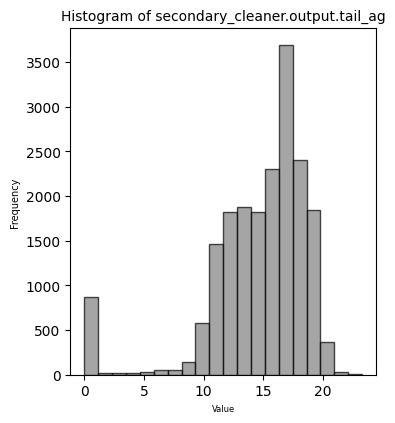

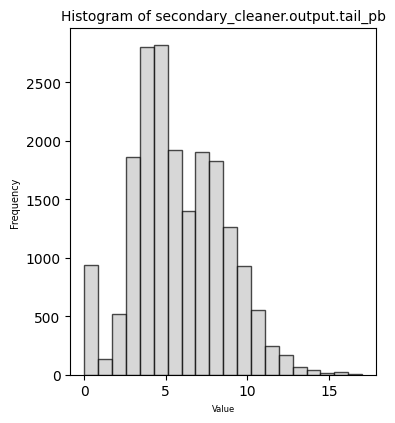

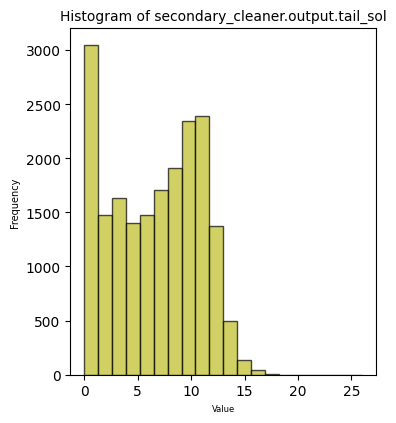

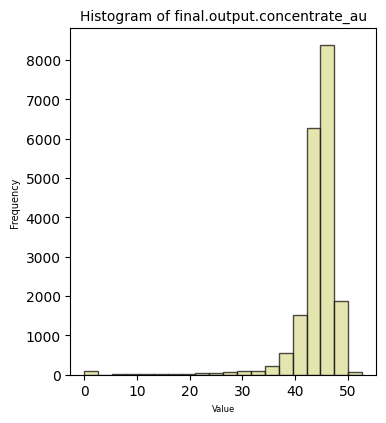

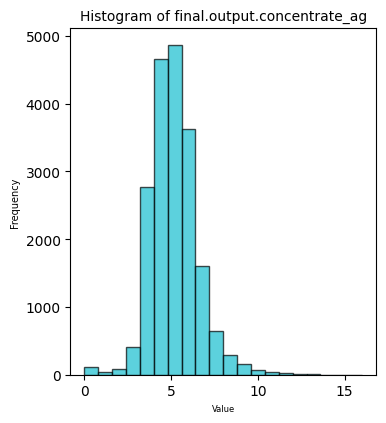

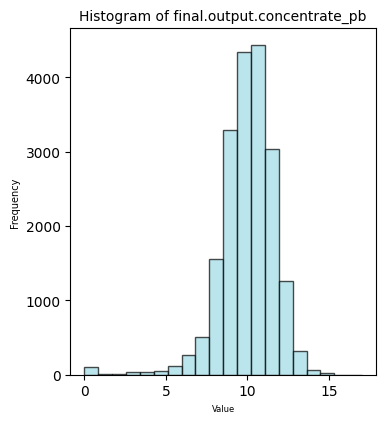

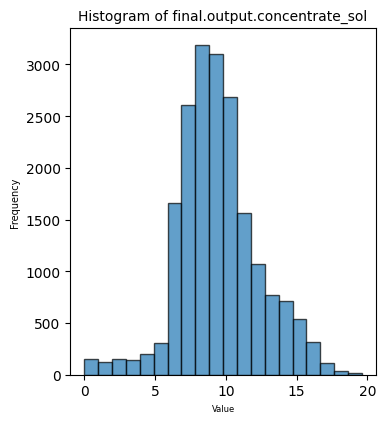

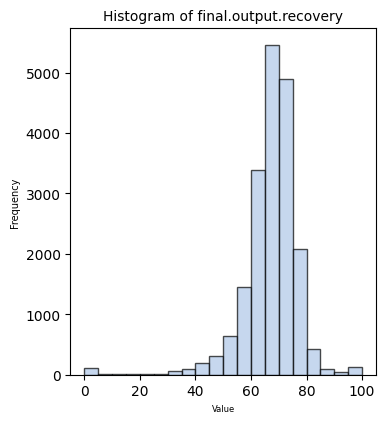

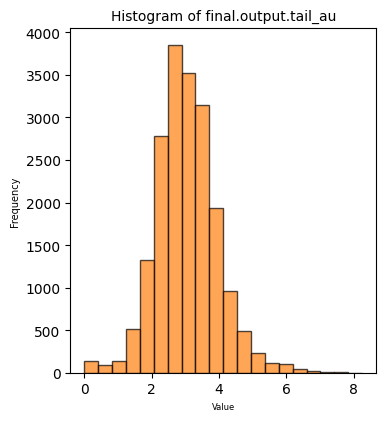

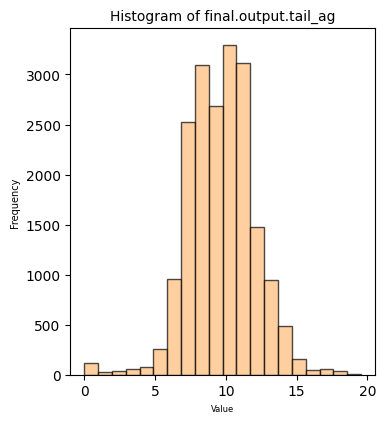

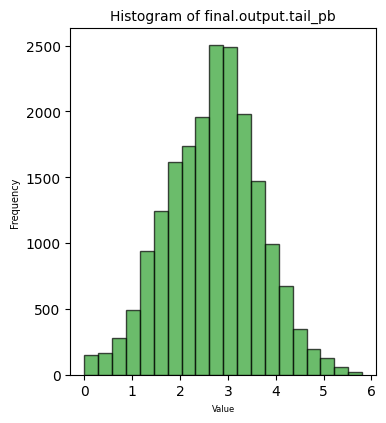

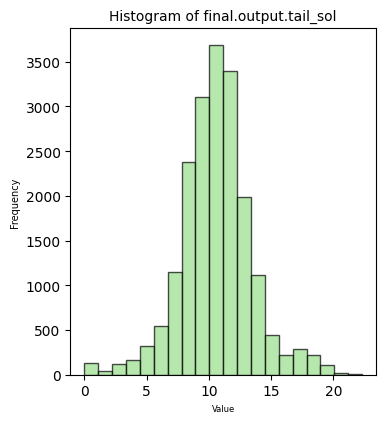

In [14]:
#Отобразим все параметры на гистограммах
colors = [cm.to_hex(plt.cm.tab20(i)) for i in range(20)]
for i, col in enumerate(column):
    fig, axes = plt.subplots(figsize=(4, 4))
    data_full_t[col].plot.hist(bins=20, alpha=0.7, color=colors[(i%20)], edgecolor='black')
    plt.tight_layout()
    plt.title(f'Histogram of {col}', fontsize=10)
    plt.xlabel('Value', fontsize=6)
    plt.ylabel('Frequency', fontsize=7)
    plt.show()

Вычислим на обучающей выборке **recovery** - коэффициент восстановления руды и сравним его с имеющимися значениями. 

In [15]:
#Применим формулу для расчета коэффициента восстановления золота в процессе флотации
data_train['rougher_recovery_calculation'] = 100* data_train['rougher.output.concentrate_au']*\
                            (data_train['rougher.input.feed_au']-data_train['rougher.output.tail_au'])\
                            /(data_train['rougher.input.feed_au']*\
                              (data_train['rougher.output.concentrate_au']-data_train['rougher.output.tail_au']))

Определим также абсолютное среднее отклонение расчетных значений и имеющихся в таблице данных.  

In [16]:
MAE = mean_absolute_error(data_train['rougher_recovery_calculation'], data_train['rougher.output.recovery'])
MAE

1.1583725420138659e-14

**Вывод**: данные по коэффициенту восстановления руды в имеющихся данных, отличаются от расчетных на незначительную величину по параметру MAE, таким образом можно утверждать, что эффективность расчитана верно. 

Определим также взаимосвязь между исходными данными для предсказания recovery для чернового и итогового концентрата. 

### Черновой концентрат

In [17]:
#Определим предварительные признаки для модели
features_r = ['rougher.input.feed_au',                                     
    'rougher.input.feed_ag',                               
    'rougher.input.feed_pb',                                    
    'rougher.input.feed_sol',                             
    'rougher.input.feed_rate',                                   
    'rougher.input.feed_size',                                   
    'rougher.input.floatbank10_sulfate',                          
    'rougher.input.floatbank10_xanthate',                         
    'rougher.state.floatbank10_a_air',                            
    'rougher.state.floatbank10_a_level',                          
    'rougher.state.floatbank10_b_air',                            
    'rougher.state.floatbank10_b_level',                          
    'rougher.state.floatbank10_c_air',                            
    'rougher.state.floatbank10_c_level',                          
    'rougher.state.floatbank10_d_air',                           
    'rougher.state.floatbank10_d_level',                          
    'rougher.state.floatbank10_e_air',                            
    'rougher.state.floatbank10_e_level',                         
    'rougher.state.floatbank10_f_air',                            
    'rougher.state.floatbank10_f_level',                          
    'rougher.input.floatbank11_sulfate',                         
    'rougher.input.floatbank11_xanthate']
target_r = 'rougher.output.recovery'

In [18]:
data_train_r = data_train[features_r]

In [19]:
#Расчитаем корреляционную матрицу для этих признаков
corr_matrix_r = data_train_r.corr()
data_train_r.corr()

rougher.input.feed_au  \
rougher.input.feed_au                            1.000000   
rougher.input.feed_ag                            0.840868   
rougher.input.feed_pb                            0.720024   
rougher.input.feed_sol                           0.127651   
rougher.input.feed_rate                         -0.175316   
rougher.input.feed_size                         -0.122949   
rougher.input.floatbank10_sulfate                0.264349   
rougher.input.floatbank10_xanthate               0.211346   
rougher.state.floatbank10_a_air                  0.193020   
rougher.state.floatbank10_a_level               -0.052107   
rougher.state.floatbank10_b_air                 -0.149031   
rougher.state.floatbank10_b_level               -0.044737   
rougher.state.floatbank10_c_air                 -0.138759   
rougher.state.floatbank10_c_level               -0.036206   
rougher.state.floatbank10_d_air                 -0.183214   
rougher.state.floatbank10_d_level               -0.030586   
rougher.state.floatbank10_e_air                 -0.151114   
rougher.state.floatbank10_e_level               -0.006841   
rougher.state.floatbank10_f_air                 -0.205337   
rougher.state.floatbank10_f_level               -0.004359   
rougher.input.floatbank11_sulfate                0.202227   
rougher.input.floatbank11_xanthate               0.125691   

                                    rougher.input.feed_ag  \
rougher.input.feed_au                            0.840868   
rougher.input.feed_ag                            1.000000   
rougher.input.feed_pb                            0.532221   
rougher.input.feed_sol                           0.144366   
rougher.input.feed_rate                         -0.112705   
rougher.input.feed_size                         -0.083810   
rougher.input.floatbank10_sulfate                0.075598   
rougher.input.floatbank10_xanthate               0.241361   
rougher.state.floatbank10_a_air                  0.316638   
rougher.state.floatbank10_a_level               -0.074911   
rougher.state.floatbank10_b_air                 -0.166860   
rougher.state.floatbank10_b_level               -0.085284   
rougher.state.floatbank10_c_air                 -0.185570   
rougher.state.floatbank10_c_level               -0.075979   
rougher.state.floatbank10_d_air                 -0.208314   
rougher.state.floatbank10_d_level               -0.069325   
rougher.state.floatbank10_e_air                 -0.105956   
rougher.state.floatbank10_e_level               -0.067779   
rougher.state.floatbank10_f_air                 -0.177115   
rougher.state.floatbank10_f_level               -0.063225   
rougher.input.floatbank11_sulfate                0.055176   
rougher.input.floatbank11_xanthate               0.170339   

                                    rougher.input.feed_pb  \
rougher.input.feed_au                            0.720024   
rougher.input.feed_ag                            0.532221   
rougher.input.feed_pb                            1.000000   
rougher.input.feed_sol                           0.110072   
rougher.input.feed_rate                         -0.136874   
rougher.input.feed_size                         -0.050069   
rougher.input.floatbank10_sulfate                0.283700   
rougher.input.floatbank10_xanthate               0.074025   
rougher.state.floatbank10_a_air                  0.270837   
rougher.state.floatbank10_a_level                0.253952   
rougher.state.floatbank10_b_air                 -0.281035   
rougher.state.floatbank10_b_level               -0.113051   
rougher.state.floatbank10_c_air                 -0.277521   
rougher.state.floatbank10_c_level               -0.102937   
rougher.state.floatbank10_d_air                 -0.340198   
rougher.state.floatbank10_d_level               -0.099780   
rougher.state.floatbank10_e_air                 -0.320483   
rougher.state.floatbank10_e_level               -0.093931   
rougher.state.floatbank10_f_air                 -0.309402   
rougher.

In [20]:
#Определим признаки между, которыми наблюдается сильная взаимосвязь
def find_index_and_row(df):
    result = []
    for index,row in df.iterrows():
        for column in df.columns:
            if (1> abs(row[column]) > 0.9):
                result.append((index,column))
    return result
find_index_and_row(corr_matrix_r)

[('rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_c_air'),
 ('rougher.state.floatbank10_b_air', 'rougher.state.floatbank10_d_air'),
 ('rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_c_level'),
 ('rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_d_level'),
 ('rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_e_level'),
 ('rougher.state.floatbank10_b_level', 'rougher.state.floatbank10_f_level'),
 ('rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_b_air'),
 ('rougher.state.floatbank10_c_air', 'rougher.state.floatbank10_d_air'),
 ('rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_b_level'),
 ('rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level'),
 ('rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_e_level'),
 ('rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_f_level'),
 ('rougher.state.floatbank10_d_air', 'rougher.state.floatbank10_b_air'),
 ('rougher.state.fl

Для устранения неточностей будущей модели для сильнокоррелирующих признаков оставим только по одному из пары. 

In [21]:
cor_features_r = ['rougher.input.floatbank11_xanthate','rougher.state.floatbank10_c_air','rougher.state.floatbank10_d_air','rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level', 'rougher.state.floatbank10_e_level', 'rougher.state.floatbank10_f_level']
for rows in cor_features_r:
    if (rows in features_r):
        features_r.remove(rows)
features_r

['rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_sol',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_e_air',
 'rougher.state.floatbank10_f_air',
 'rougher.input.floatbank11_sulfate']

### Итоговый концентрат

In [22]:
 features_f = [ 'secondary_cleaner.state.floatbank2_a_air',    
   'secondary_cleaner.state.floatbank2_a_level',  
  'secondary_cleaner.state.floatbank2_b_air',    
 'secondary_cleaner.state.floatbank2_b_level',  
 'secondary_cleaner.state.floatbank3_a_air',    
  'secondary_cleaner.state.floatbank3_a_level',  
 'secondary_cleaner.state.floatbank3_b_air',    
 'secondary_cleaner.state.floatbank3_b_level',  
'secondary_cleaner.state.floatbank4_a_air',    
 'secondary_cleaner.state.floatbank4_a_level',  
  'secondary_cleaner.state.floatbank4_b_air',    
  'secondary_cleaner.state.floatbank4_b_level',  
  'secondary_cleaner.state.floatbank5_a_air',    
  'secondary_cleaner.state.floatbank5_a_level',  
 'secondary_cleaner.state.floatbank5_b_air',    
  'secondary_cleaner.state.floatbank5_b_level',  
 'secondary_cleaner.state.floatbank6_a_air',    
 'secondary_cleaner.state.floatbank6_a_level']  
target_f = 'final.output.recovery'

In [23]:
data_train_f = data_train[features_f]
#Расчитаем корреляционную матрицу для этих признаков
corr_matrix_f = data_train_f.corr()
data_train_f.corr()

secondary_cleaner.state.floatbank2_a_air  \
secondary_cleaner.state.floatbank2_a_air                                    1.000000   
secondary_cleaner.state.floatbank2_a_level                                  0.520342   
secondary_cleaner.state.floatbank2_b_air                                    0.880963   
secondary_cleaner.state.floatbank2_b_level                                  0.525620   
secondary_cleaner.state.floatbank3_a_air                                    0.384759   
secondary_cleaner.state.floatbank3_a_level                                 -0.029770   
secondary_cleaner.state.floatbank3_b_air                                    0.293730   
secondary_cleaner.state.floatbank3_b_level                                 -0.063597   
secondary_cleaner.state.floatbank4_a_air                                    0.435224   
secondary_cleaner.state.floatbank4_a_level                                  0.003652   
secondary_cleaner.state.floatbank4_b_air                                    0.378350   
secondary_cleaner.state.floatbank4_b_level                                 -0.040633   
secondary_cleaner.state.floatbank5_a_air                                    0.335312   
secondary_cleaner.state.floatbank5_a_level                                 -0.035992   
secondary_cleaner.state.floatbank5_b_air                                    0.364706   
secondary_cleaner.state.floatbank5_b_level                                 -0.040866   
secondary_cleaner.state.floatbank6_a_air                                    0.019115   
secondary_cleaner.state.floatbank6_a_level                                  0.009930   

                                            secondary_cleaner.state.floatbank2_a_level  \
secondary_cleaner.state.floatbank2_a_air                                      0.520342   
secondary_cleaner.state.floatbank2_a_level                                    1.000000   
secondary_cleaner.state.floatbank2_b_air                                      0.406776   
secondary_cleaner.state.floatbank2_b_level                                    0.898639   
secondary_cleaner.state.floatbank3_a_air                                     -0.164724   
secondary_cleaner.state.floatbank3_a_level                                   -0.041104   
secondary_cleaner.state.floatbank3_b_air                                     -0.089602   
secondary_cleaner.state.floatbank3_b_level                                    0.201470   
secondary_cleaner.state.floatbank4_a_air                                     -0.146084   
secondary_cleaner.state.floatbank4_a_level                                   -0.064950   
secondary_cleaner.state.floatbank4_b_air                                     -0.226546   
secondary_cleaner.state.floatbank4_b_level                                   -0.032761   
secondary_cleaner.state.floatbank5_a_air                                     -0.220211   
secondary_cleaner.state.floatbank5_a_level                                    0.062671   
secondary_cleaner.state.floatbank5_b_air                                     -0.230869   
secondary_cleaner.state.floatbank5_b_level                                    0.052815   
secondary_cleaner.state.floatbank6_a_air                                     -0.057130   
secondary_cleaner.state.floatbank6_a_level                                    0.075460   

                                            secondary_cleaner.state.floatbank2_b_air  \
secondary_cleaner.state.floatbank2_a_air                                    0.880963   
secondary_cleaner.state.floatbank2_a_level                                  0.406776   
secondary_cleaner.state.floatbank2_b_air                                    1.000000   
secondary_cleaner.state.floatbank2_b_level                                  0.411457   
secondary_cleaner.state.floatbank3_a_air                                    0.468100   
secondary_cleaner.state.floatbank3_a_level                                 -0.067594   
secondary_cleaner.state.floatbank3_b_air    

In [24]:
#Определим признаки между, которыми наблюдается сильная взаимосвязь
def find_index_and_row(df):
    result = []
    for index,row in df.iterrows():
        for column in df.columns:
            if (1> abs(row[column]) > 0.9):
                result.append((index,column))
    return result
find_index_and_row(corr_matrix_f)

[]

**Вывод**: сильнокоррелирующих признаков в этом случае нет. 

**Общий вывод**: была проведена предварительная обработка данных. Проанализированы пропущенные значения, дубликаты, изменен тип данных date с object на datetime. Для обучающей выборки были проведены расчеты параметра recovery для процесса флотации, которые с незначительной долей ошибки (порядка -14 степени) совпали с имеющимися в исходных данных. Было обнаружено, что в тестовой выборке отсутствуют целевые параметры и выходные характеристики для каждого технологического процесса. 

Восстановим пропущенные значения в тестовых данных из полной таблицы. 

In [25]:
data_test = data_test.merge(data_full[['final.output.recovery', 'rougher.output.recovery', 'date']], how='left', on='date')
data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4860 entries, 0 to 4859
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        4860 non-null   datetime64[ns]
 1   rougher.input.feed_au                       4860 non-null   float64       
 2   rougher.input.feed_ag                       4860 non-null   float64       
 3   rougher.input.feed_pb                       4860 non-null   float64       
 4   rougher.input.feed_sol                      4860 non-null   float64       
 5   rougher.input.feed_rate                     4860 non-null   float64       
 6   rougher.input.feed_size                     4860 non-null   float64       
 7   rougher.input.floatbank10_sulfate           4860 non-null   float64       
 8   rougher.input.floatbank10_xanthate          4860 non-null   float64       
 9   rougher.

# 2. Анализ данных

## 2.1 Изменение концентраций 

Изучим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

### Золото

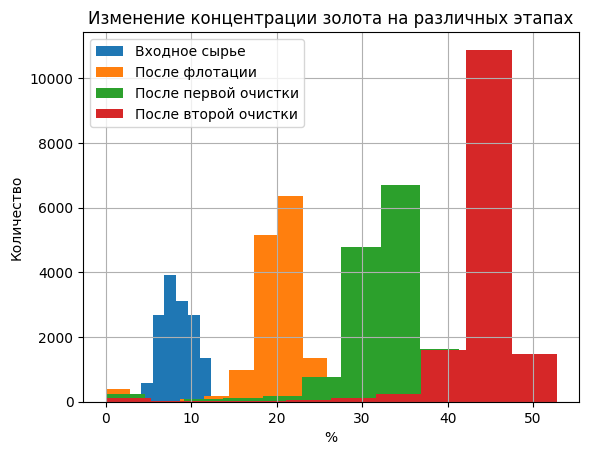

In [26]:
#Отобразим, как изменяется концентрация золота на разных этапах
data_train['rougher.input.feed_au'].hist()
data_train['rougher.output.concentrate_au'].hist() 
data_train['primary_cleaner.output.concentrate_au'].hist() 
data_train['final.output.concentrate_au'].hist() 
plt.title('Изменение концентрации золота на различных этапах')
plt.xlabel('%')
plt.ylabel('Количество')
plt.legend(['Входное сырье', 'После флотации', 'После первой очистки', 'После второй очистки']);

**Вывод**: четко прослеживается, что после каждого этапа очистки, доля золота в материале увеличивается. Также можно отметить определенную долю выбивающихся малых концентраций.

In [27]:
#Уберем часть малых концентраций
data_train = data_train.loc[data_train['rougher.input.feed_au'] > data_train['rougher.input.feed_au'].quantile(.001)]
data_train = data_train.loc[data_train['rougher.output.concentrate_au'] > data_train['rougher.output.concentrate_au'].quantile(.001)]
data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_au'] > data_train['primary_cleaner.output.concentrate_au'].quantile(.001)]
data_train = data_train.loc[data_train['final.output.concentrate_au'] > data_train['final.output.concentrate_au'].quantile(.001)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13974 entries, 0 to 14578
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                13974 non-null  datetime64[ns]
 1   rougher.input.feed_au                               13974 non-null  float64       
 2   rougher.input.feed_ag                               13974 non-null  float64       
 3   rougher.input.feed_pb                               13974 non-null  float64       
 4   rougher.input.feed_sol                              13974 non-null  float64       
 5   rougher.input.feed_rate                             13974 non-null  float64       
 6   rougher.input.feed_size                             13974 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   13974 non-null  float64       
 8   roughe

### Серебро

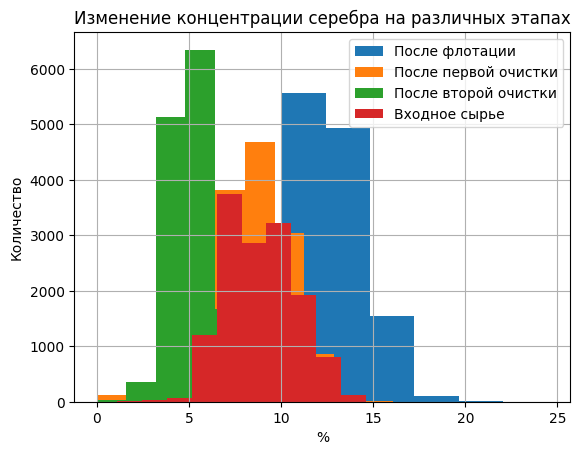

In [28]:
#Отобразим, как изменяется концентрация серебра на разных этапах
data_train['rougher.output.concentrate_ag'].hist() 
data_train['primary_cleaner.output.concentrate_ag'].hist() 
data_train['final.output.concentrate_ag'].hist() 
data_train['rougher.input.feed_ag'].hist()
plt.title('Изменение концентрации серебра на различных этапах')
plt.xlabel('%')
plt.ylabel('Количество')
plt.legend(['После флотации', 'После первой очистки', 'После второй очистки', 'Входное сырье']);

**Вывод**: видно, что на первых этапах обработки доля серебра незначительно увеличивается, но после второго этапа очистки становится минимальной. Аналогично, можно отметить выбивающиеся малые концентрации. 

In [29]:
#Уберем часть малых концентраций
data_train = data_train.loc[data_train['rougher.input.feed_ag'] > data_train['rougher.input.feed_ag'].quantile(.001)]
data_train = data_train.loc[data_train['rougher.output.concentrate_ag'] > data_train['rougher.output.concentrate_ag'].quantile(.001)]
data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_ag'] > data_train['primary_cleaner.output.concentrate_ag'].quantile(.001)]
data_train = data_train.loc[data_train['final.output.concentrate_ag'] > data_train['final.output.concentrate_ag'].quantile(.001)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13846 entries, 0 to 14578
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                13846 non-null  datetime64[ns]
 1   rougher.input.feed_au                               13846 non-null  float64       
 2   rougher.input.feed_ag                               13846 non-null  float64       
 3   rougher.input.feed_pb                               13846 non-null  float64       
 4   rougher.input.feed_sol                              13846 non-null  float64       
 5   rougher.input.feed_rate                             13846 non-null  float64       
 6   rougher.input.feed_size                             13846 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   13846 non-null  float64       
 8   roughe

### Свинец

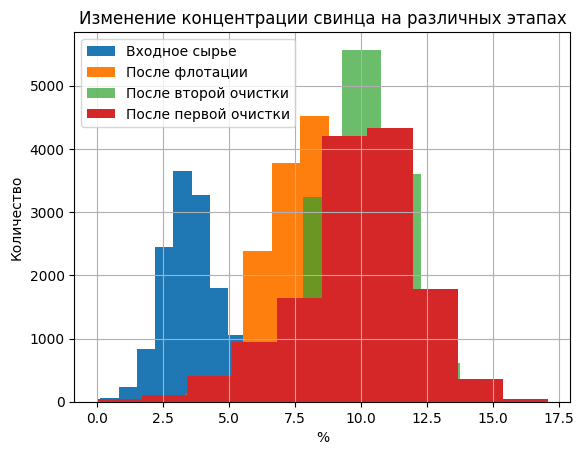

In [30]:
#Отобразим, как изменяется концентрация свинца на разных этапах
data_train['rougher.input.feed_pb'].hist()
data_train['rougher.output.concentrate_pb'].hist() 
data_train['final.output.concentrate_pb'].hist(alpha = 0.7) 
data_train['primary_cleaner.output.concentrate_pb'].hist() 
plt.title('Изменение концентрации свинца на различных этапах')
plt.xlabel('%')
plt.ylabel('Количество')
plt.legend(['Входное сырье', 'После флотации', 'После второй очистки', 'После первой очистки']);

**Вывод**: доля свинца после первых двух этапов обработки увеличивается, после второго этапа очистки незначительно уменьшается. 

In [31]:
#Уберем часть малых концентраций
data_train = data_train.loc[data_train['rougher.input.feed_pb'] > data_train['rougher.input.feed_pb'].quantile(.001)]
data_train = data_train.loc[data_train['rougher.output.concentrate_pb'] > data_train['rougher.output.concentrate_pb'].quantile(.001)]
data_train = data_train.loc[data_train['primary_cleaner.output.concentrate_pb'] > data_train['primary_cleaner.output.concentrate_pb'].quantile(.001)]
data_train = data_train.loc[data_train['final.output.concentrate_pb'] > data_train['final.output.concentrate_pb'].quantile(.001)]
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13790 entries, 0 to 14578
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                13790 non-null  datetime64[ns]
 1   rougher.input.feed_au                               13790 non-null  float64       
 2   rougher.input.feed_ag                               13790 non-null  float64       
 3   rougher.input.feed_pb                               13790 non-null  float64       
 4   rougher.input.feed_sol                              13790 non-null  float64       
 5   rougher.input.feed_rate                             13790 non-null  float64       
 6   rougher.input.feed_size                             13790 non-null  float64       
 7   rougher.input.floatbank10_sulfate                   13790 non-null  float64       
 8   roughe

## 2.2 Распределения размеров гранул

Проведем сравнение размеров гранул исходного сырья для тестовой и для обучающей выборок. 

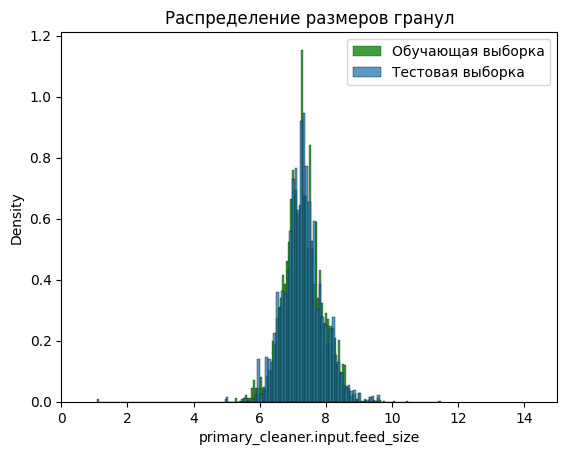

In [32]:
sns.histplot(data_train['primary_cleaner.input.feed_size'], stat='density', color = 'green')
sns.histplot(data_test['primary_cleaner.input.feed_size'],stat='density')
plt.title('Распределение размеров гранул')
plt.legend(['Обучающая выборка', 'Tестовая выборка'])
plt.xlim(0,15);

In [33]:
data_train['rougher.input.feed_size'].describe()

count    13790.000000
mean        58.796054
std         23.387570
min          0.049194
25%         47.165955
50%         54.301270
75%         64.206993
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [34]:
data_test['rougher.input.feed_size'].describe()

count    4860.000000
mean       59.080175
std        19.441844
min         0.046369
25%        47.605339
50%        55.414175
75%        66.538910
max       363.989699
Name: rougher.input.feed_size, dtype: float64

**Вывод**: параметры распределения размеров гранул в тестовой и в обучающей выборке не имеют значительных отличий, а поэтому пригодны для дальнейшего исследования.

## 2.3 Cуммарная концентрация металлов

Исследуем суммарную концентрацию металлов на разных стадиях: в сырье, в черновом концентрате, в концентрате после первой очистки и в финальном концентрате.

In [35]:
#Рассчитаем суммарные концентрации металлов для всех стадий
data_train['sum_input'] =  data_train['rougher.input.feed_au']+data_train['rougher.input.feed_ag']+data_train['rougher.input.feed_pb']
data_train['sum_rougher_output'] = data_train['rougher.output.concentrate_au']+data_train['rougher.output.concentrate_ag']+data_train['rougher.output.concentrate_pb']
data_train['sum_primary_cleaner_output']=data_train['primary_cleaner.output.concentrate_au']+data_train['primary_cleaner.output.concentrate_ag']+data_train['primary_cleaner.output.concentrate_pb']
data_train['sum_final_output']= data_train['final.output.concentrate_au']+data_train['final.output.concentrate_ag']+data_train['final.output.concentrate_pb']

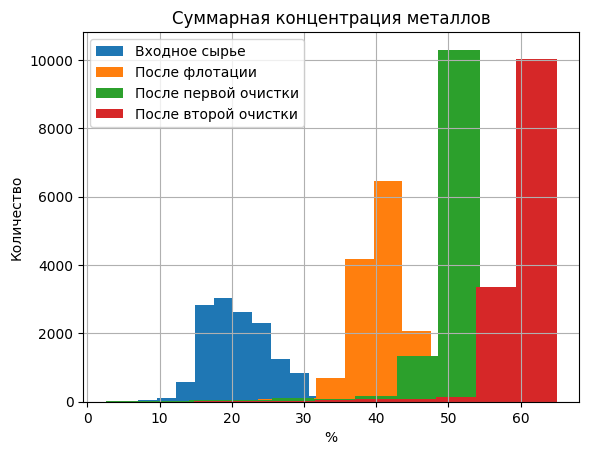

In [36]:
#Отобразим графически суммарную концентрацию металлов на каждом этапе обработки
data_train['sum_input'].hist()
data_train['sum_rougher_output'].hist()
data_train['sum_primary_cleaner_output'].hist()
data_train['sum_final_output'].hist()
plt.title('Cуммарная концентрация металлов')
plt.xlabel('%')
plt.ylabel('Количество')
plt.legend(['Входное сырье', 'После флотации', 'После первой очистки', 'После второй очистки']);

**Вывод**: суммарная концентрация всех металлов после каждого этапа последовательно увеличивается. 

## 3. Построение модели 

Для построения модели воспользуемся метрикой качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

In [37]:
#Функции для расчета метрики sMAPE
def sMAPE_calculation(predictions,target):
    sMAPE = 100*(abs(target - predictions))/((abs(target)+abs(predictions))/2)
    return (sMAPE.sum())/sMAPE.count()

In [38]:
def total_sMAPE(rougher, final):
    return 0.25*rougher+0.75*final

In [39]:
#Сделаем оценочную функцию для дальнешейго использования
scorer = make_scorer(sMAPE_calculation, greater_is_better=False)

## 3.1 Линейная регрессия

Воспользуемся изначально линейной регрессией для моделирования чернового и итогового концентратов. 

In [40]:
#Подготовим признаки для модели
features_train_r = data_train[features_r]
target_train_r = data_train['rougher.output.recovery']
features_test_r = data_test[features_r] 
target_test_r = data_test['rougher.output.recovery']
features_train_f = data_train[features_f]
target_train_f = data_train['rougher.output.recovery']
features_test_f = data_test[features_f] 
target_test_f = data_test['rougher.output.recovery']

In [41]:
#Проведем масштабирование данных
scaler = StandardScaler()
pd.options.mode.chained_assignment = None
scaler.fit(features_train_r[features_r]) 
features_train_r[features_r] = scaler.transform(features_train_r[features_r])
features_test_r[features_r] = scaler.transform(features_test_r[features_r])
features_train_r.head()

rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  \
0              -1.011465              -1.476189              -1.252397   
1              -1.015496              -1.444107              -1.270374   
2              -1.077495              -1.467697              -1.371700   
3              -1.207517              -1.506334              -1.487694   
4              -1.449669              -1.497034              -1.726634   

   rougher.input.feed_sol  rougher.input.feed_rate  rougher.input.feed_size  \
0                0.036474                 0.447984                -0.141510   
1               -0.172002                 0.464417                -0.064882   
2               -0.128884                 0.509038                -0.054963   
3                0.047073                 0.627408                -0.042901   
4               -0.449729                 0.608014                -0.117540   

   rougher.input.floatbank10_sulfate  rougher.input.floatbank10_xanthate  \
0                          -0.128146                           -0.018308   
1                          -0.132748                           -0.020284   
2                          -0.147842                            0.149957   
3                          -0.234520                            0.155110   
4                          -0.435122                            0.151244   

   rougher.state.floatbank10_a_air  rougher.state.floatbank10_a_level  \
0                        -0.636331                          -0.242094   
1                        -0.632732                          -0.200010   
2                        -0.636252                          -0.200103   
3                        -0.635661                          -0.201430   
4                        -0.636506                          -0.196724   

   rougher.state.floatbank10_b_air  rougher.state.floatbank10_b_level  \
0                         1.526521                           0.532481   
1                         1.514029                           0.261910   
2                         1.506184                           0.260932   
3                         1.510181                           0.250076   
4                         1.511008                           0.268193   

   rougher.state.floatbank10_e_air  rougher.state.floatbank10_f_air  \
0                         1.752403                         2.269470   
1                         1.723430                         2.172018   
2                         1.723175                         2.175516   
3                         1.732910                         2.175036   
4                         1.736322                         2.180458   

   rougher.input.floatbank11_sulfate  
0                          -0.073524  
1                          -0.031812  
2                          -0.051660  
3                          -0.111278  
4                          -0.302787

In [42]:
#Обучим линейную регрессию для чернового концентрата
model_r = LinearRegression()
sMape_rougher = cross_val_score(model_r,  
                                X=features_train_r, 
                                y=target_train_r, 
                                scoring = scorer
                                )


In [43]:
#Значение метрики качества
abs(sMape_rougher).mean()

6.557199626246449

In [44]:
#Обучим линейную регрессию для итогового концентрата
model_f = LinearRegression()
sMape_final = cross_val_score(model_f,  
                                X=features_train_f, 
                                y=target_train_f, 
                                scoring = scorer
                                )


In [45]:
#Значение метрики качества
abs(sMape_final).mean()

6.946623360012251

In [46]:
#Итоговое значение метрики качества 
total_sMAPE(abs(sMape_rougher).mean(), abs(sMape_final).mean())

6.849267426570801

## 3.2 Модель случайного леса

Воспользуемся теперь моделью случайного леса и подберем наилучшие параметры для данной модели. 

In [47]:
#Определим модель случайного леса и подберем наилучшие параметры
best_model_tree_r = None
best_result_tree_r = 10**100
best_depth = 0
best_number_of_trees = 0
for est in range(10, 200, 20):
        for depth in range (2, 10, 2):
            model_random_tree_r = RandomForestRegressor(random_state=12345, n_estimators= est, max_depth = depth) 
            sMape_rougher = cross_val_score(model_random_tree_r,  
                                X=features_train_r, 
                                y=target_train_r, 
                                scoring = scorer
                                )
            result = abs(sMape_rougher).mean()
            if result < best_result_tree_r:
                best_model_tree_r = model_random_tree_r
                best_result_tree_r = result
                best_depth = depth
                best_number_of_trees = est
print('Наилучшее число деревьев', best_number_of_trees)
print('Наилучшая глубина', best_depth)
print('Лучший результат по средней sMape метрике', best_result_tree_r )

Наилучшее число деревьев 10
Наилучшая глубина 2
Лучший результат по средней sMape метрике 6.115227535898571


In [48]:
#Определим модель случайного леса и подберем наилучшие параметры
best_model_tree_f = None
best_result_tree_f = 10**100
best_depth = 0
best_number_of_trees = 0
for est in range(50, 300, 100):
        for depth in range (2, 12, 4):
            model_random_tree_f = RandomForestRegressor(random_state=12345, n_estimators= est, max_depth = depth) 
            sMape_final = cross_val_score(model_random_tree_f,  
                                X=features_train_f, 
                                y=target_train_f, 
                                scoring = scorer
                                )
            result = abs(sMape_final).mean()
            if result < best_result_tree_f:
                best_model_tree_f = model_random_tree_f
                best_result_tree_f = result
                best_depth = depth
                best_number_of_trees = est
print('Наилучшее число деревьев', best_number_of_trees)
print('Наилучшая глубина', best_depth)
print('Лучший результат по средней sMape метрике', best_result_tree_f)

Наилучшее число деревьев 150
Наилучшая глубина 2
Лучший результат по средней sMape метрике 6.559635967612168


Итоговые вычисления для параметра sMape

In [49]:
total_sMAPE(best_result_tree_r, best_result_tree_f)

6.448533859683769

**Вывод**: проведя исследование двух моделей машинного обучения с использованием оценки sMAPE на кросс-валидации мы установили, что наилучше моделью в данном случае будет являться модель случайного леса с параметрами:

- наилучшая глубина - 
- наилучшее число деревьев - 
- с оценкой sMAPE на обучающей выборке 

## 3.3 Проверка модели на тестовых данных и на адекватность

Проверим теперь полученную модель на тестовых данных 

In [50]:
#Проверим наилучшую из полученных моделей на тестовой выборке
#для чернового концентрата
best_model_tree_r.fit(features_train_r, target_train_r)
predictions_r = best_model_tree_r.predict(features_test_r)
rougher = sMAPE_calculation(predictions_r,target_test_r)
#для итогового
best_model_tree_f.fit(features_train_f, target_train_f)
predictions_f = best_model_tree_f.predict(features_test_f)
final = sMAPE_calculation(predictions_f,target_test_f)
#конечный параметр sMAPE
total_sMAPE(rougher, final)

4.964008012959449

**Вывод**: при проверке полученной модели на тестовых данных получаем значение sMape = **4.96**

Проверим теперь нашу модель на адекватность, сравнив качество ее предсказаний с качеством модели, предсказывающей константу. 

In [51]:
#Cоздадим константную модель для чернового концентрата
model_dummy_r = DummyRegressor(strategy="mean")
model_dummy_r.fit(features_train_r, target_train_r)
predictions_dummy_r = model_dummy_r.predict(features_test_r)
#Рассчитаем sMape
rougher_dummy = sMAPE_calculation(predictions_dummy_r,target_test_r)

In [52]:
#Cоздадим константную модель для финального концентрата
model_dummy_f = DummyRegressor(strategy="mean")
model_dummy_f.fit(features_train_f, target_train_f)
predictions_dummy_f = model_dummy_f.predict(features_test_f)
#Рассчитаем sMape
final_dummy = sMAPE_calculation(predictions_dummy_f,target_test_f)

In [53]:
total_sMAPE(rougher_dummy, final_dummy)

6.082362118975026

**Вывод**: таким образом мы получаем, что для тестовых данных значение sMAPE для наилучшей модели составило - **4.64**.
Для проверки на адекватность была использована модель Dummy Regressor для которой такое же значение составило **6.08**.
Таким образом, созданная нами модель является адекватной. 

# Выводы

В ходе проекта были исследованные данные компании "Цифра", характеризующие процесс обработки полезных ископаемаемых, а именно технологические процессы по извлечению золота из поступающей руды. Имеющиеся данные (изначально разделенные на обучающую, тестовую и общую выборки) были предварительно обработаны. 

Были исследованы пропуски и дубликаты имеющихся значений. Пропуски были заменены на ближайшие значения, поскольку это согласуется с имеющейся информацией о данных. Проанализированы полученные распределения всех представленных параметров. 

В качестве анализа исходных данных было проанализировано изменение концентрации разных металлов - золота, серебра и свинца на разных стадиях производства. Было отмечено наличие незначительного количества материалов с низкими концентрациями и для корректности разрабатываемых моделей подобные данные были удалены. 

Проанализированы взаимосвязи в исходных переменных для устранения возможных проблем с переобучением и устранены сильно коррелирующие между собой аналоги. 

Проведено сравнение распределение размеров гранул для обучающей выборки и для тестовой. Распределения имеют незначительные отличия в своих основных характеристиках (средние значения, дисперсия), что говорит о том, что выбор тестовой выборки произведен корректно. 

Произведено обучение двух моделей - линейной регрессии и случайного дерева. В качестве меры качества полученных моделей был использован параметр sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»). Именно на его основе происходил отбор наилучшей модели. 

Для модели **линейной регрессии** итоговое значение параметра sMAPE на обучающей выборке было равно **6.84**. 

Для моделей случайного дерева были подобраны следующие параметры:
- для чернового концентрата - **10 деревьев с глубиной 2**
- для итогового концентрата - **150 деревьев с глубиной 2**. <br>

Итоговое значение параметра sMAPE на обучающей выборке для этих моделей было равно **6.44**. 


Таким образом, наилучшая модель - **модель случайного леса**. При проверке параметра качества на тестовой выборке для этой модели был получен резульатат **4.96**.  Данная модель позволяет предсказывать степень очистки сырья, тем самым служит инструментом оптимизации производства. 